In [0]:
!pip install tensorflow-gpu
!pip install gdown

     |████████████████████████████████| 380.8MB 79kB/s 
     |████████████████████████████████| 3.8MB 30.6MB/s 
     |████████████████████████████████| 450kB 38.8MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Goodness of fit

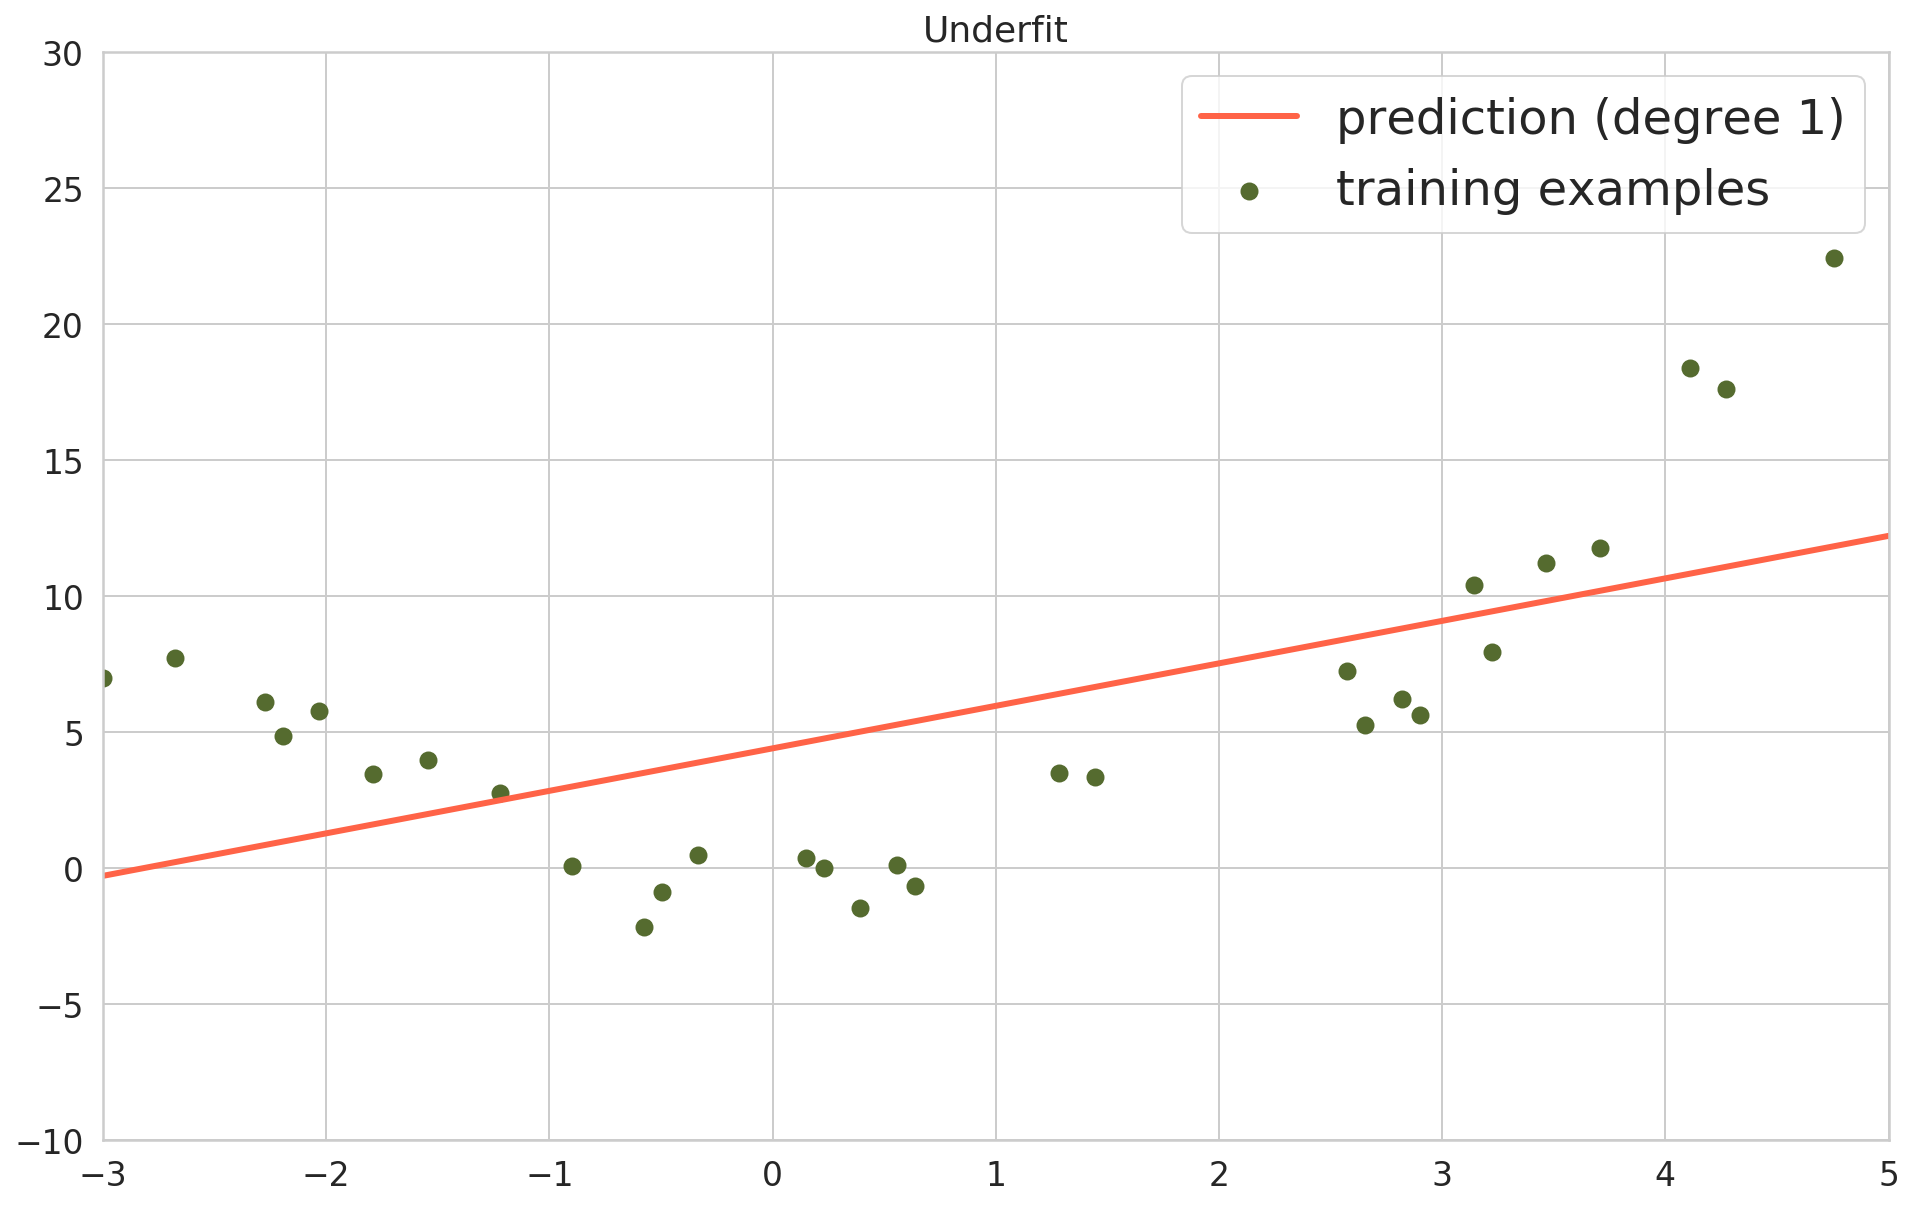

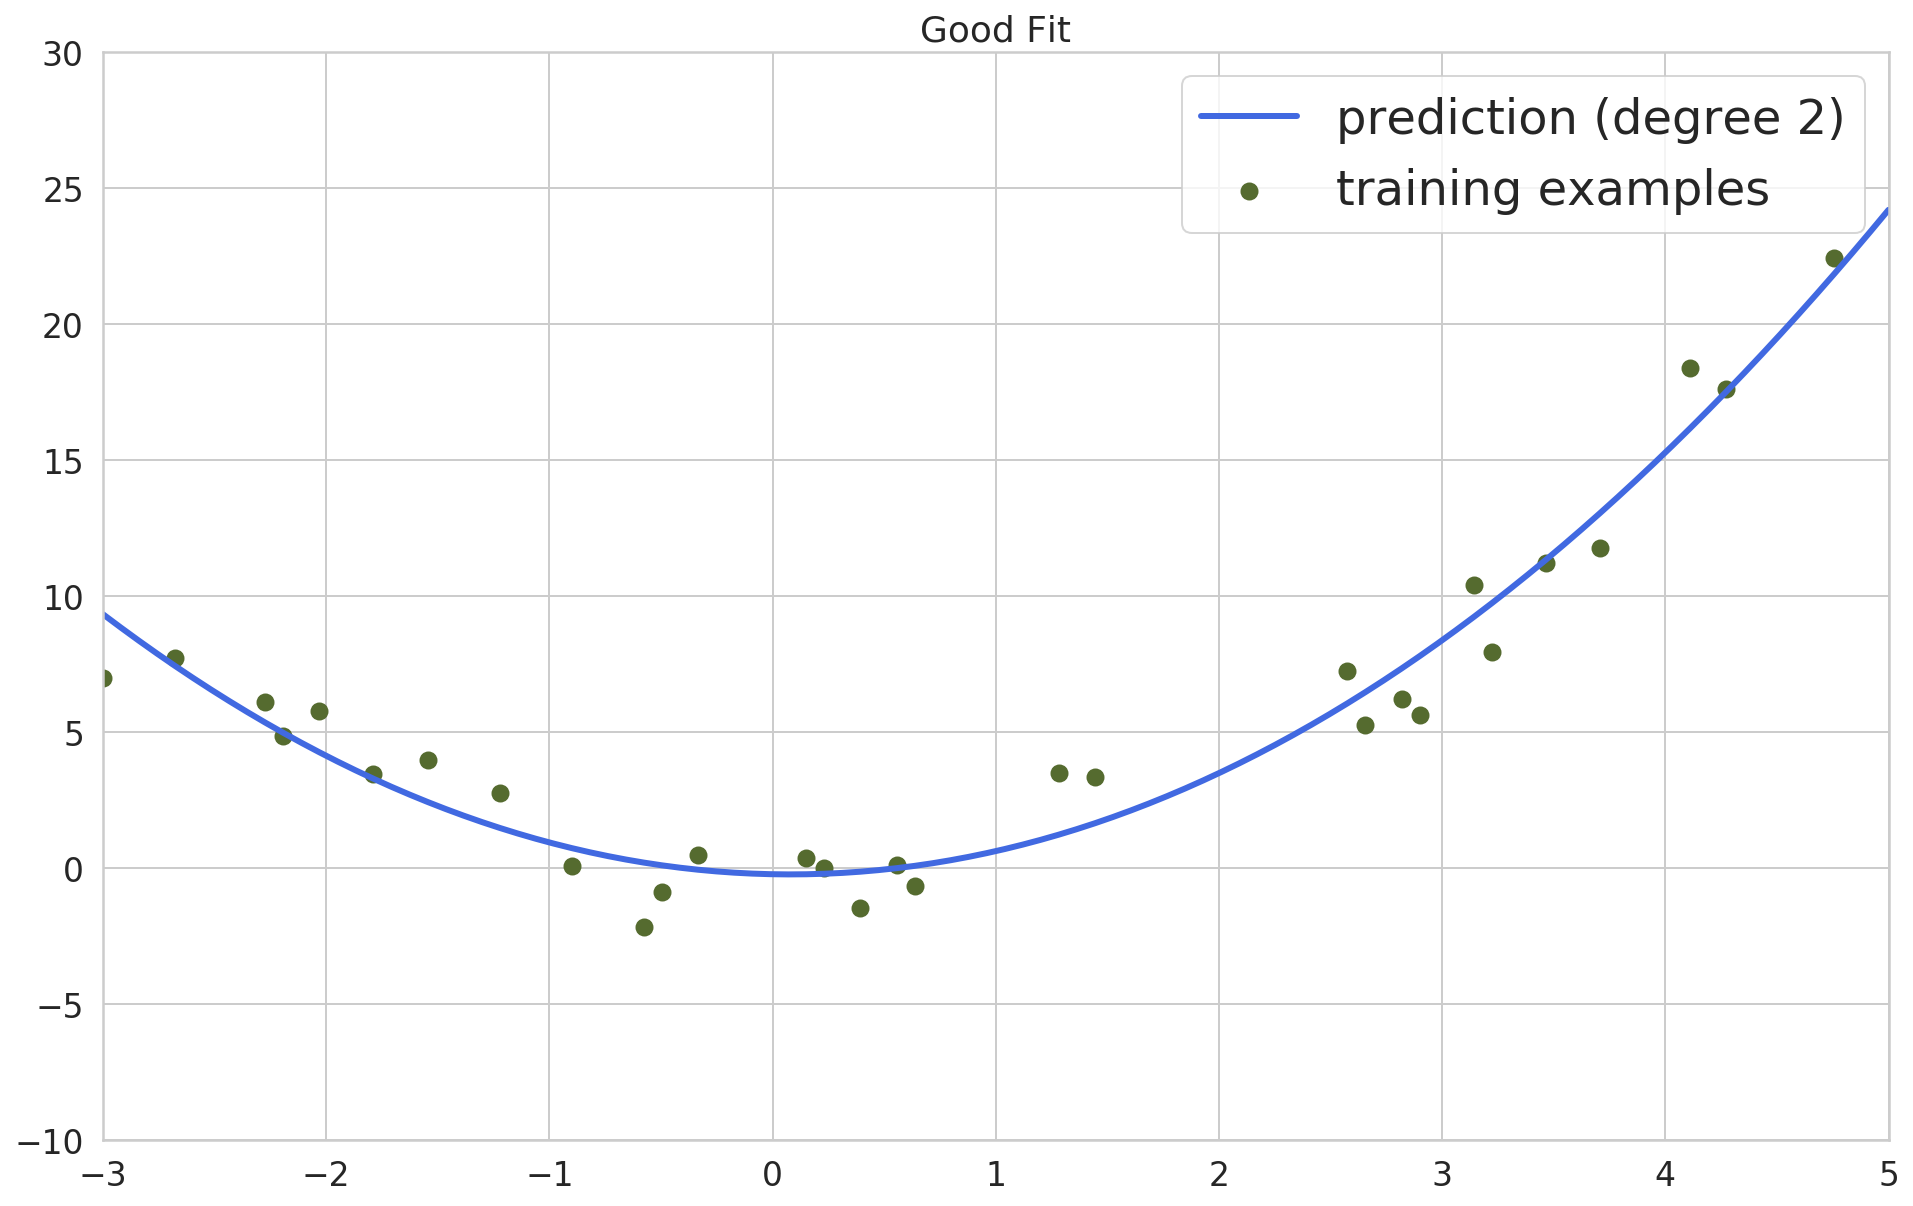

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.96664e-21): result may not be accurate.
  overwrite_a=True).T


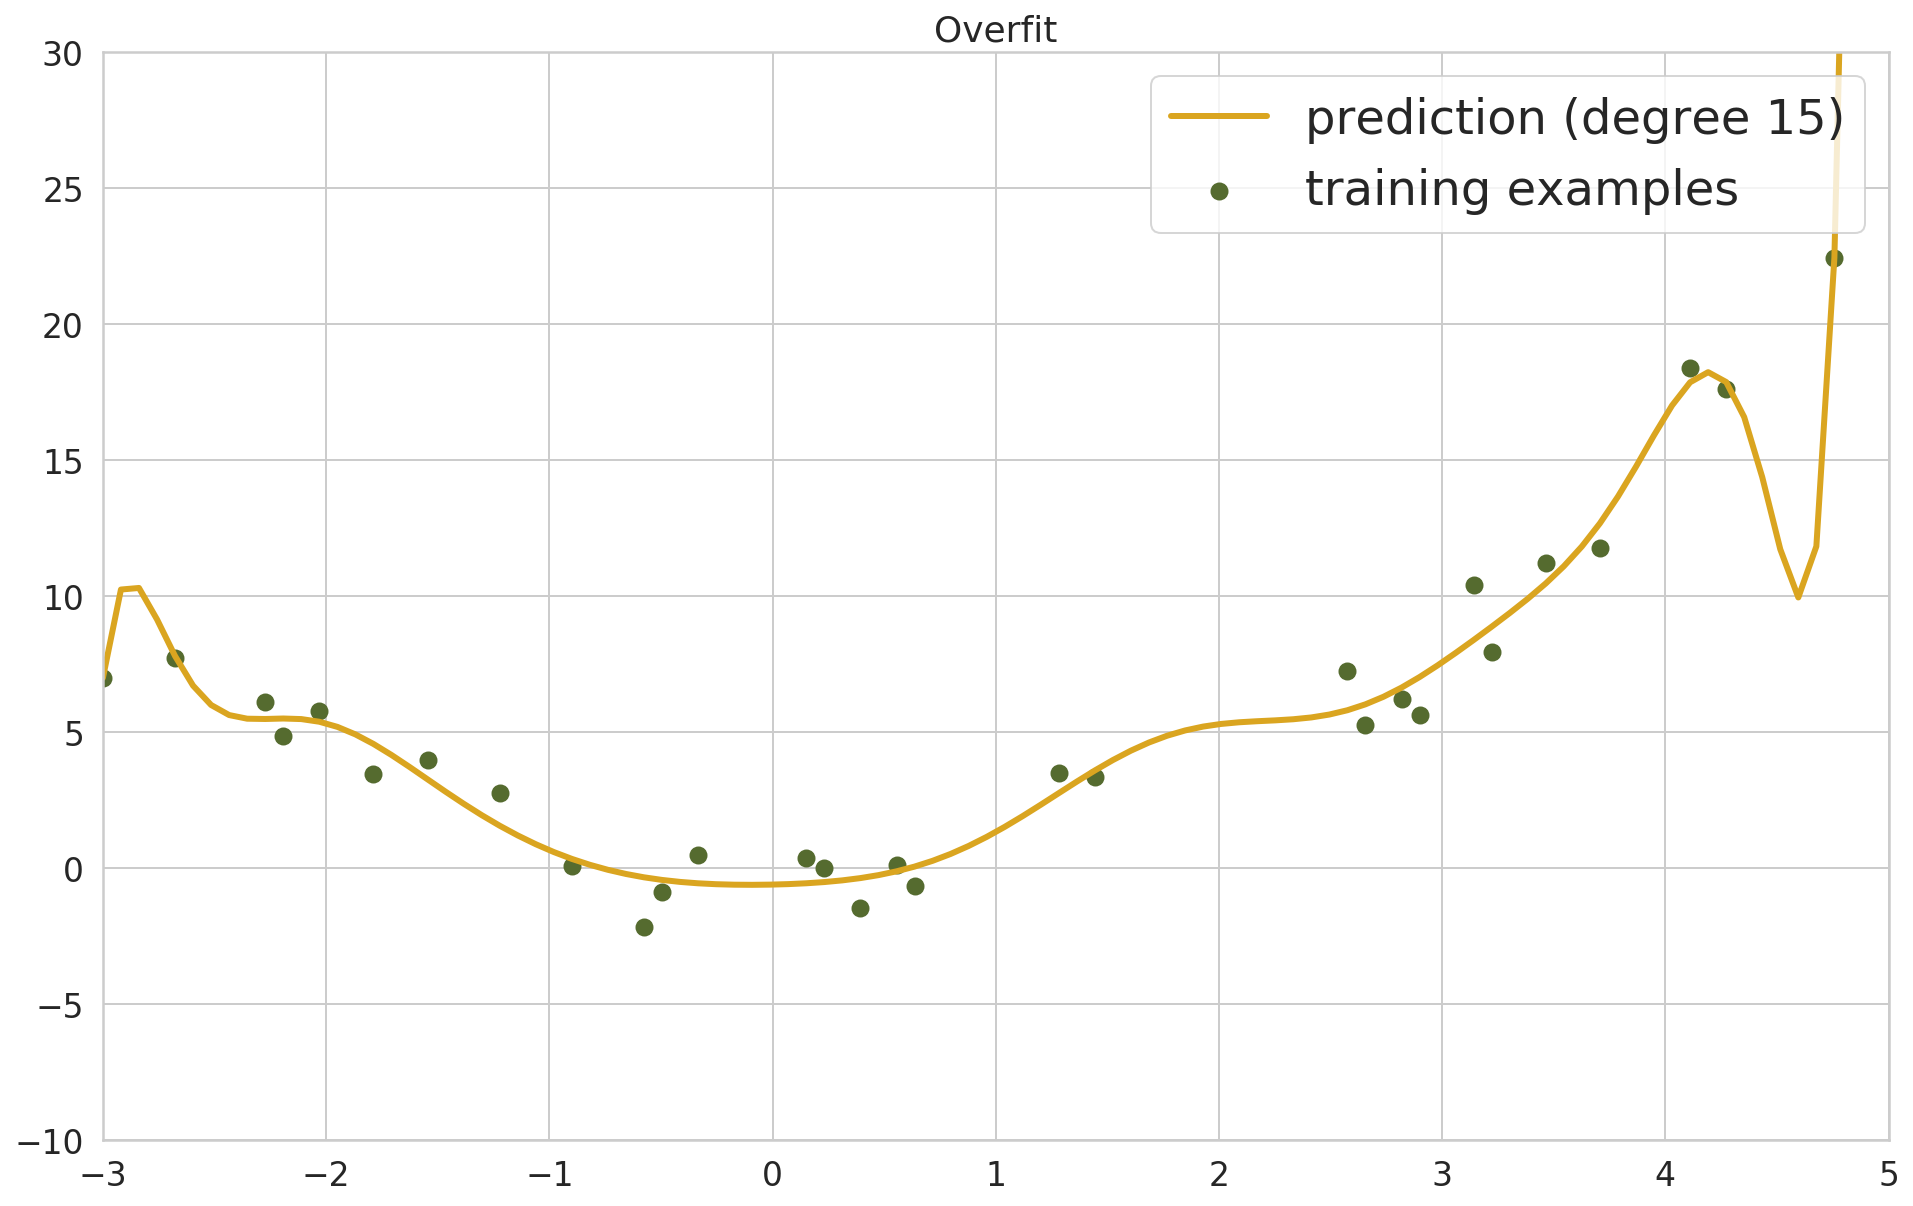

In [0]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.linspace(-3, 5, 100)

np.random.shuffle(X)
X = np.sort(X[:30])
noise = [(-3 + np.random.random()*5) for i in range(len(X))]
y = X * X + noise

X = np.expand_dims(X, axis=1)

x_plot = np.linspace(-3, 5, 100)
y_test = np.expand_dims(x_plot, axis=1)

colors = ['tomato', 'royalblue', 'goldenrod']
lw = 3

fit = ["Underfit", "Good Fit", "Overfit"]
for count, degree in enumerate([1, 2, 15]):
    plt.xlim([-3, 5])
    plt.ylim([-10, 30])
    plt.scatter(X, y, color='darkolivegreen', s=64, marker='o', label="training examples")
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_pred = model.predict(y_test)
    plt.plot(x_plot, y_pred, color=colors[count], linewidth=lw,
             label=f'prediction (degree {degree})')

    plt.legend(loc='upper right', prop={'size': 24})
    plt.title(fit[count])
    plt.show()

# Data

In [0]:
!gdown --id 1rsxu0CKFfI-xR1pH-5JQHcfZ7MIa08Q6 --output heart.csv

Downloading...
From: https://drive.google.com/uc?id=1rsxu0CKFfI-xR1pH-5JQHcfZ7MIa08Q6
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 9.78MB/s]


In [0]:
df = pd.read_csv('heart.csv')

In [0]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [0]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
df.shape

(303, 14)

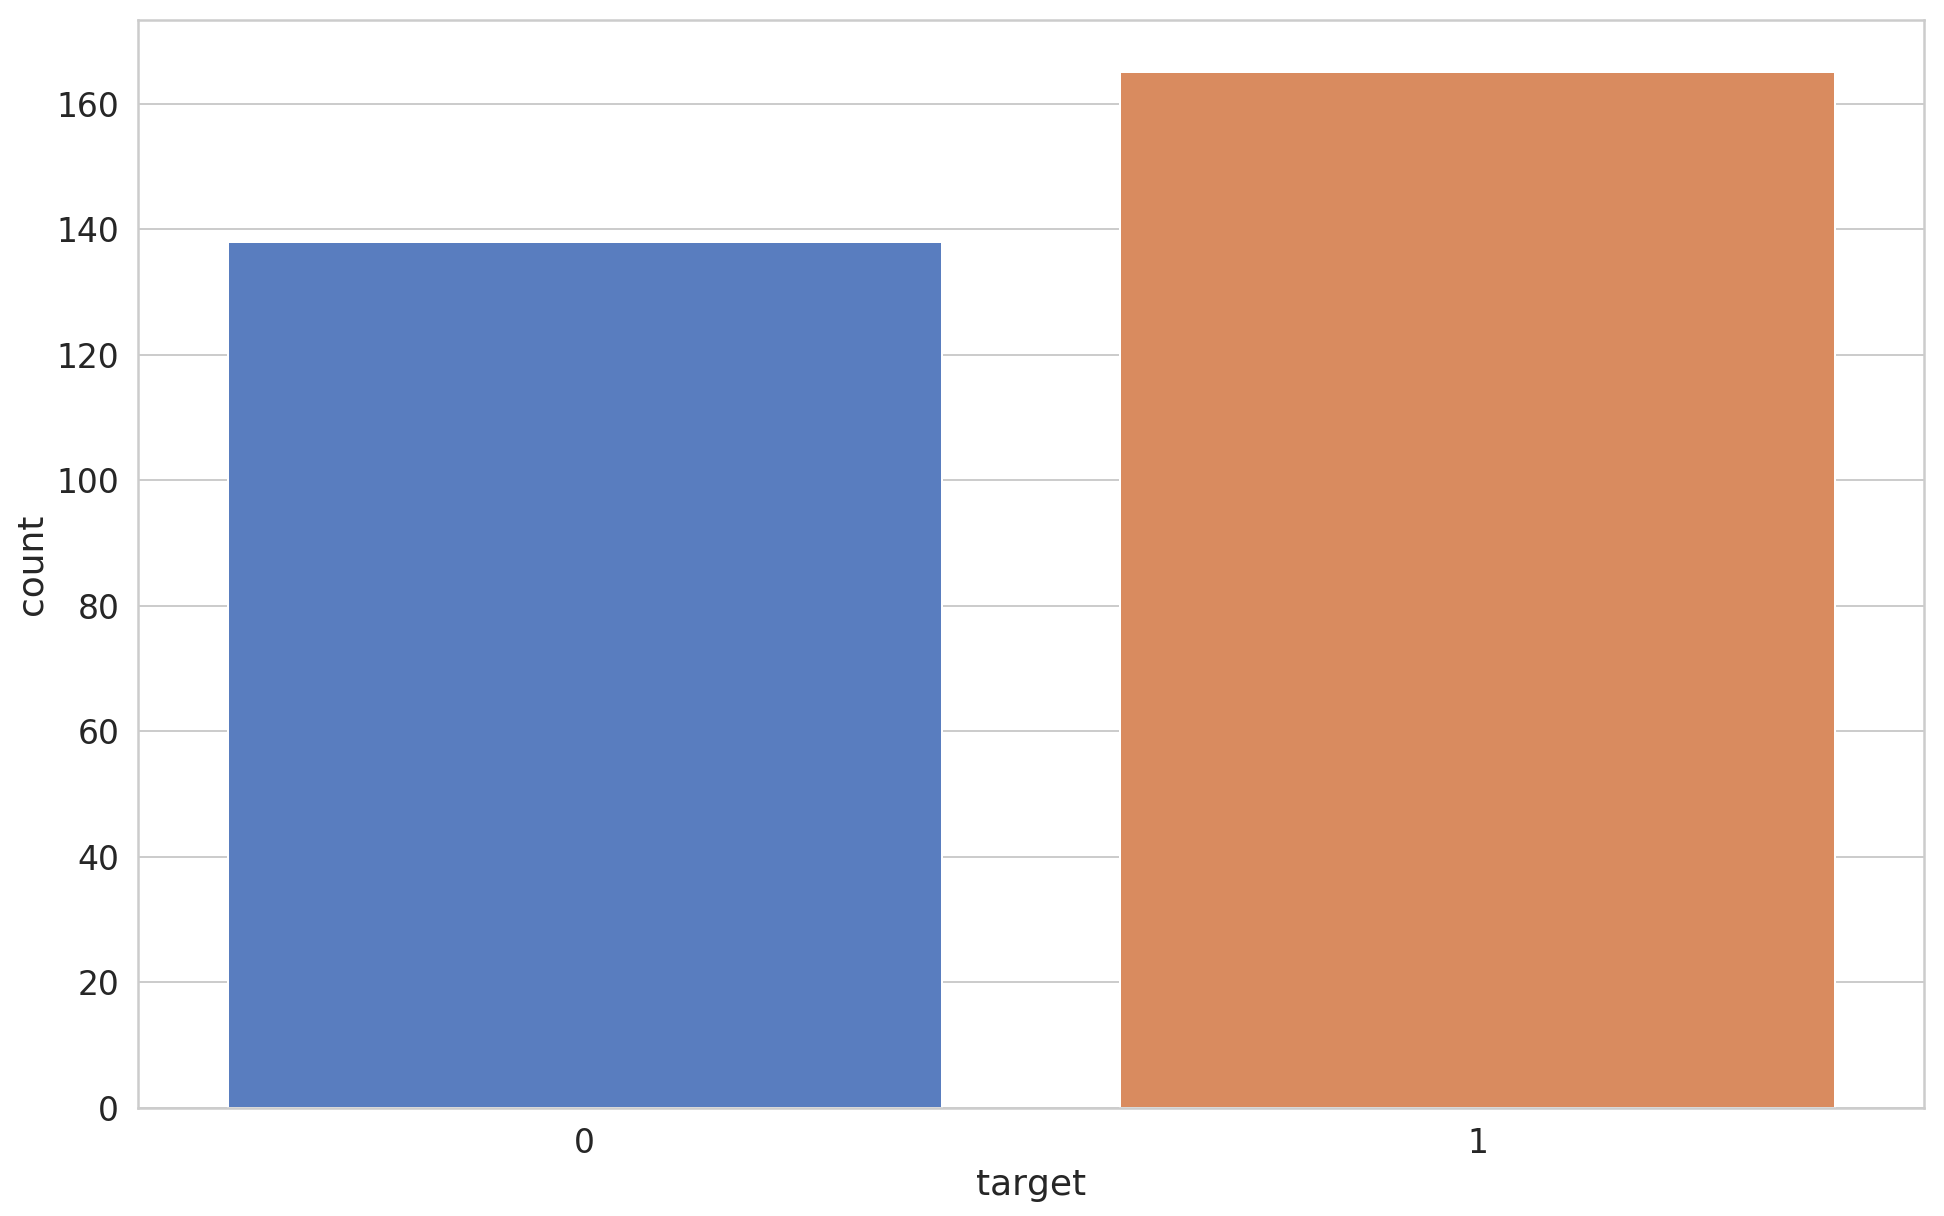

In [0]:
sns.countplot(df.target);

In [0]:
df.isnull().values.any()

False

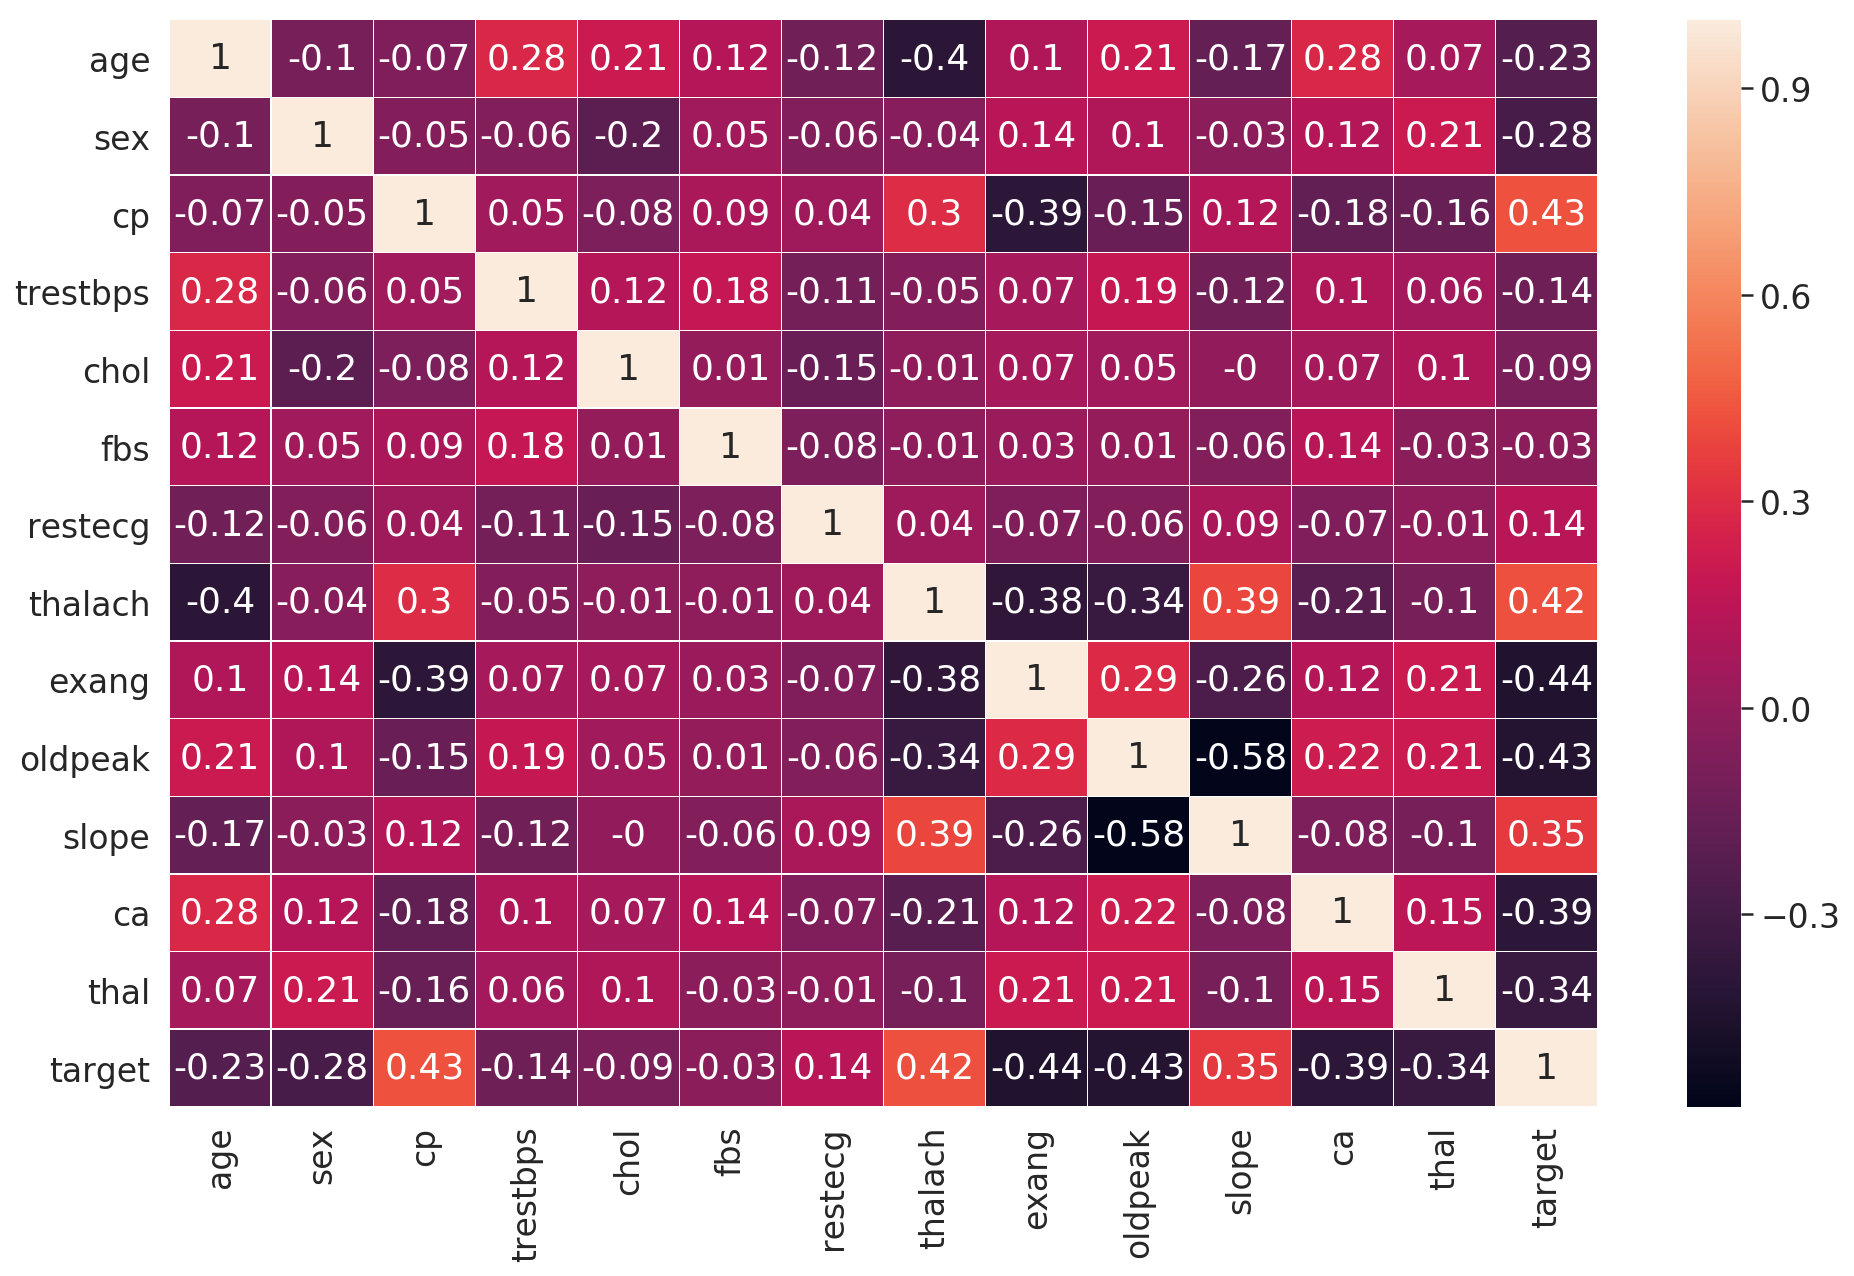

In [0]:
sns.heatmap(df.corr().round(decimals=2), annot = True, linewidths=.2);

In [0]:
 top_cor = abs(df.corr()).sort_values('target', ascending=False).index.values[1:]

In [0]:
top_cor

array(['exang', 'cp', 'oldpeak', 'thalach', 'ca', 'slope', 'thal', 'sex',
       'age', 'trestbps', 'restecg', 'chol', 'fbs'], dtype=object)

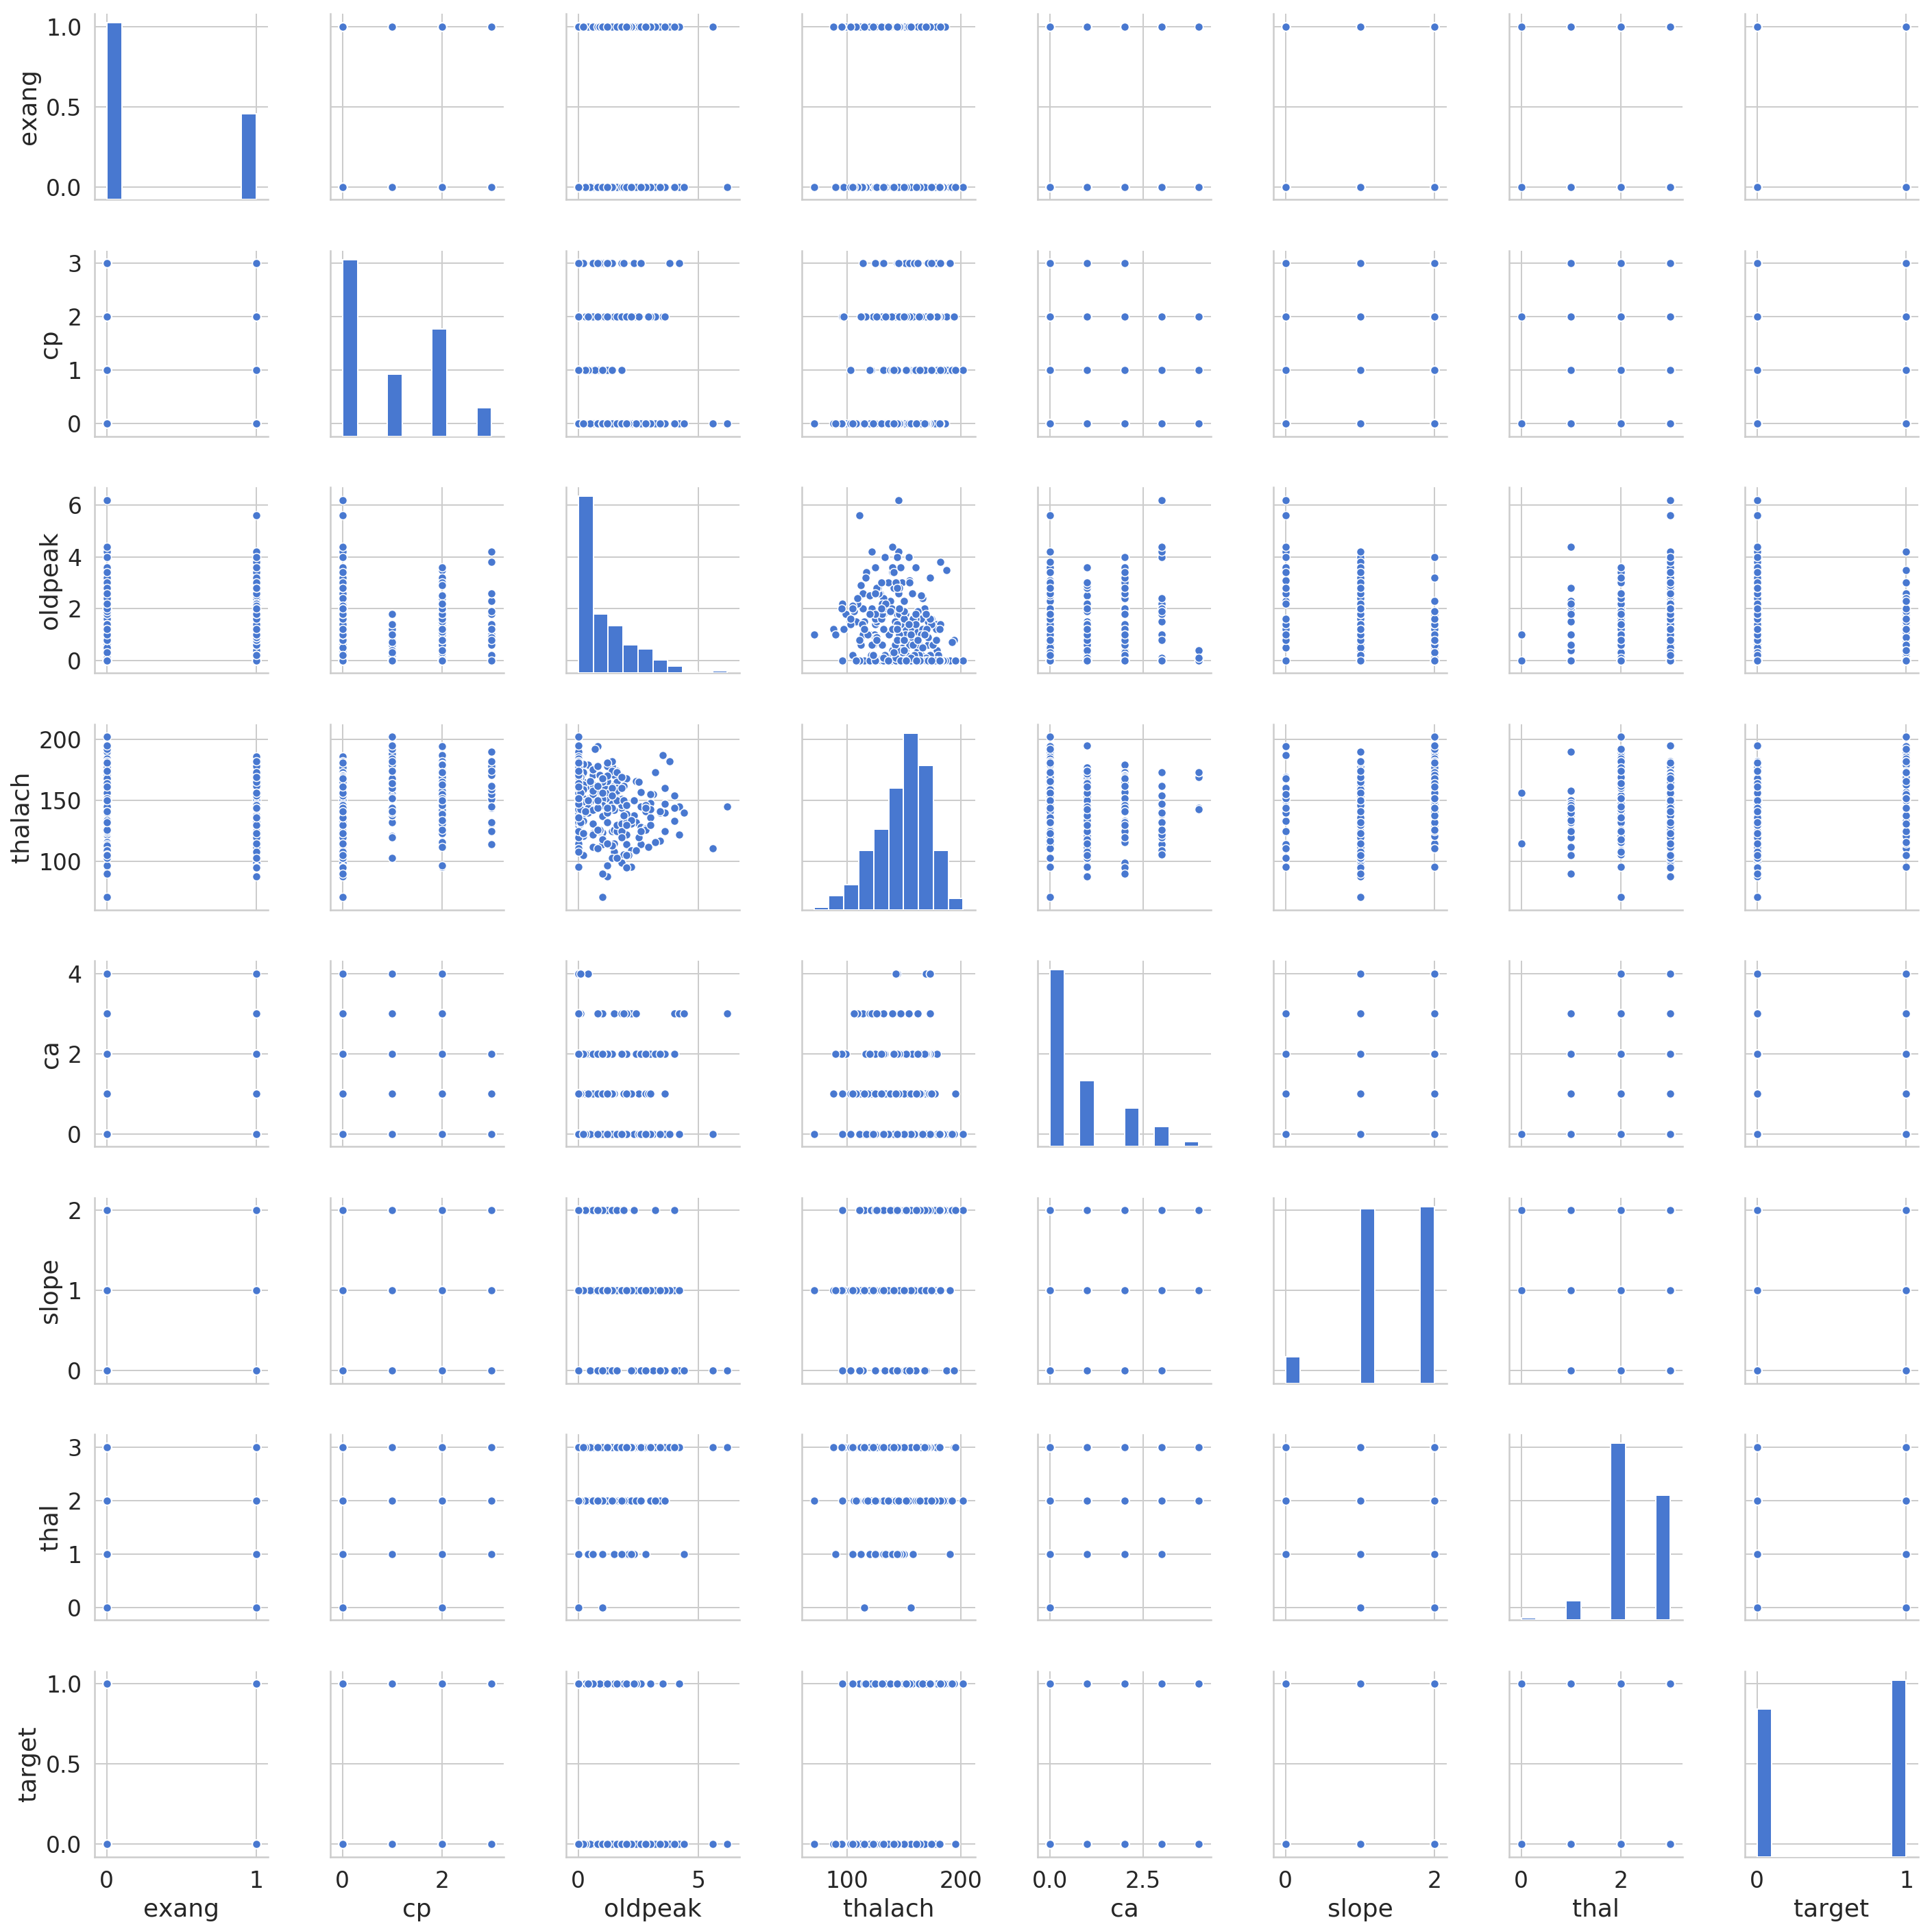

In [0]:
sns.pairplot(df[np.append(top_cor[:7], ["target"])]);

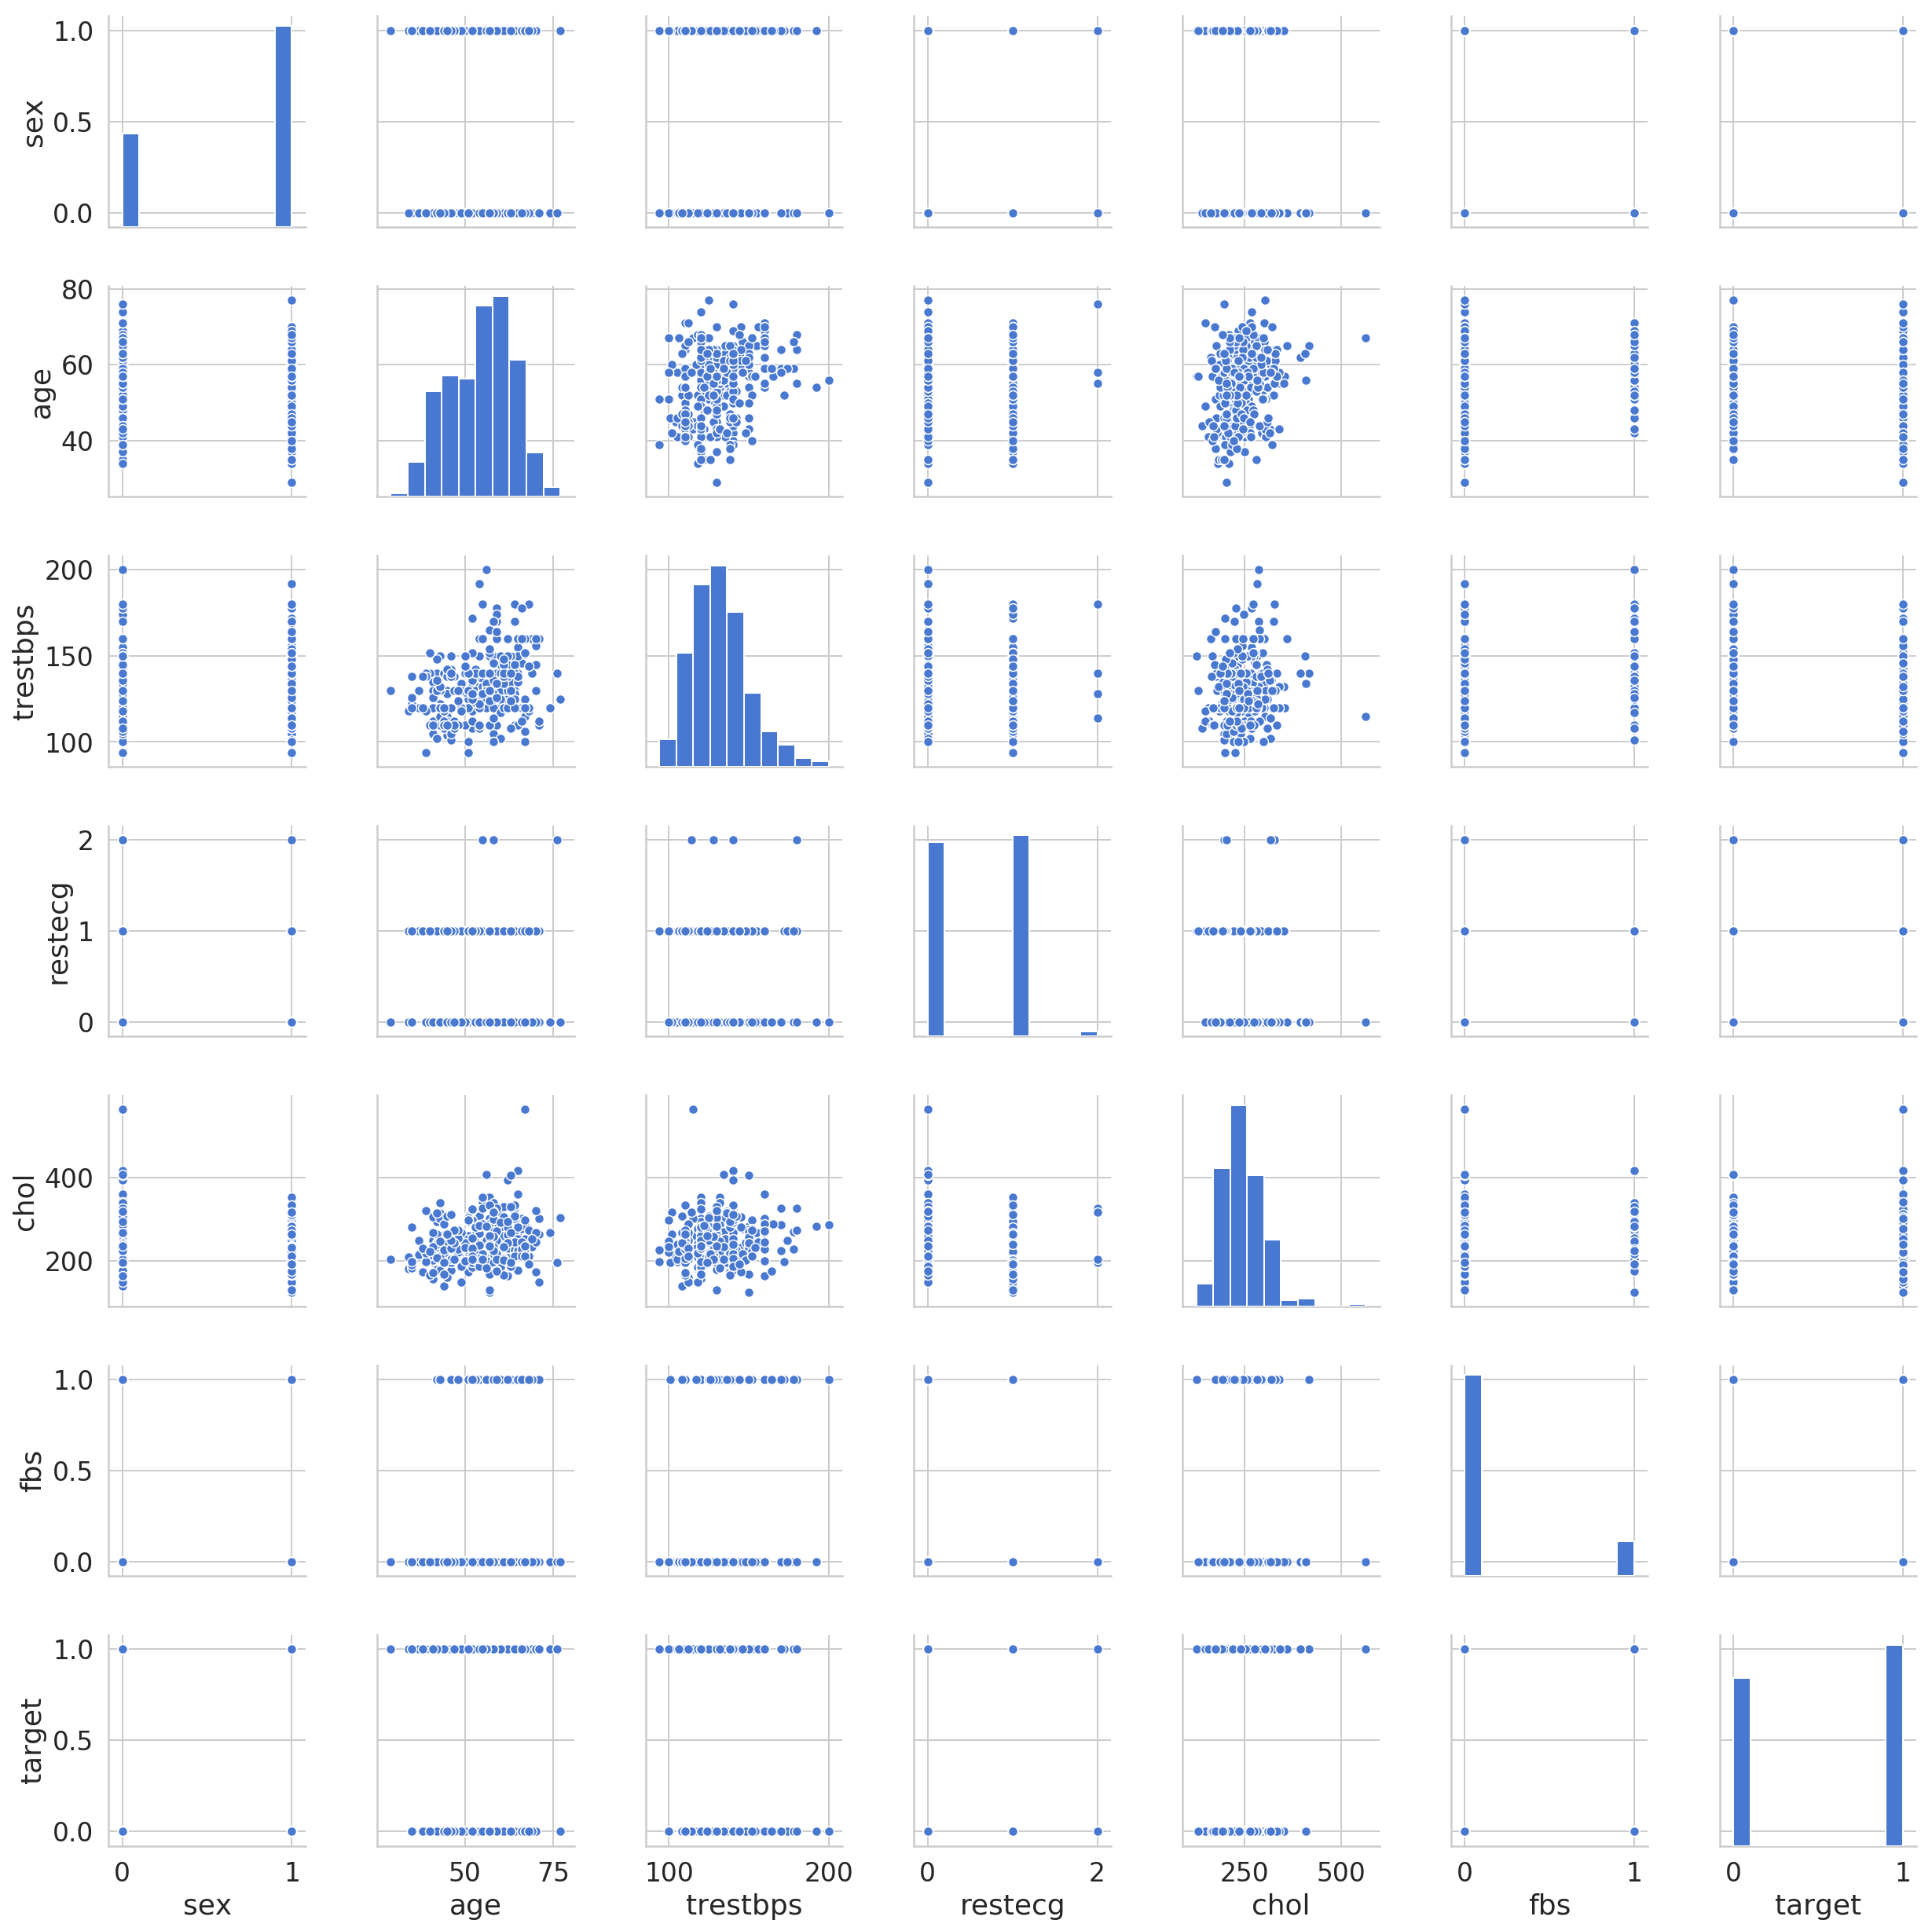

In [0]:
sns.pairplot(df[np.append(top_cor[7:], ["target"])]);

# Underfitting

## Non informative feature

In [0]:
from sklearn.model_selection import train_test_split

X = df[['trestbps']]
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
X_train.shape

(242, 1)

In [0]:
def build_classifier(train_data):
  model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=[train_data.shape[1]]),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=1),
  ])

  model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
  )

  return model

In [0]:
clf = build_classifier(X_train)

In [0]:
BATCH_SIZE = 32

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

In [0]:
def plot_accuracy(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
            label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
            label = 'Val Accuracy')
  plt.ylim((0, 1))
  plt.legend()
  plt.show()

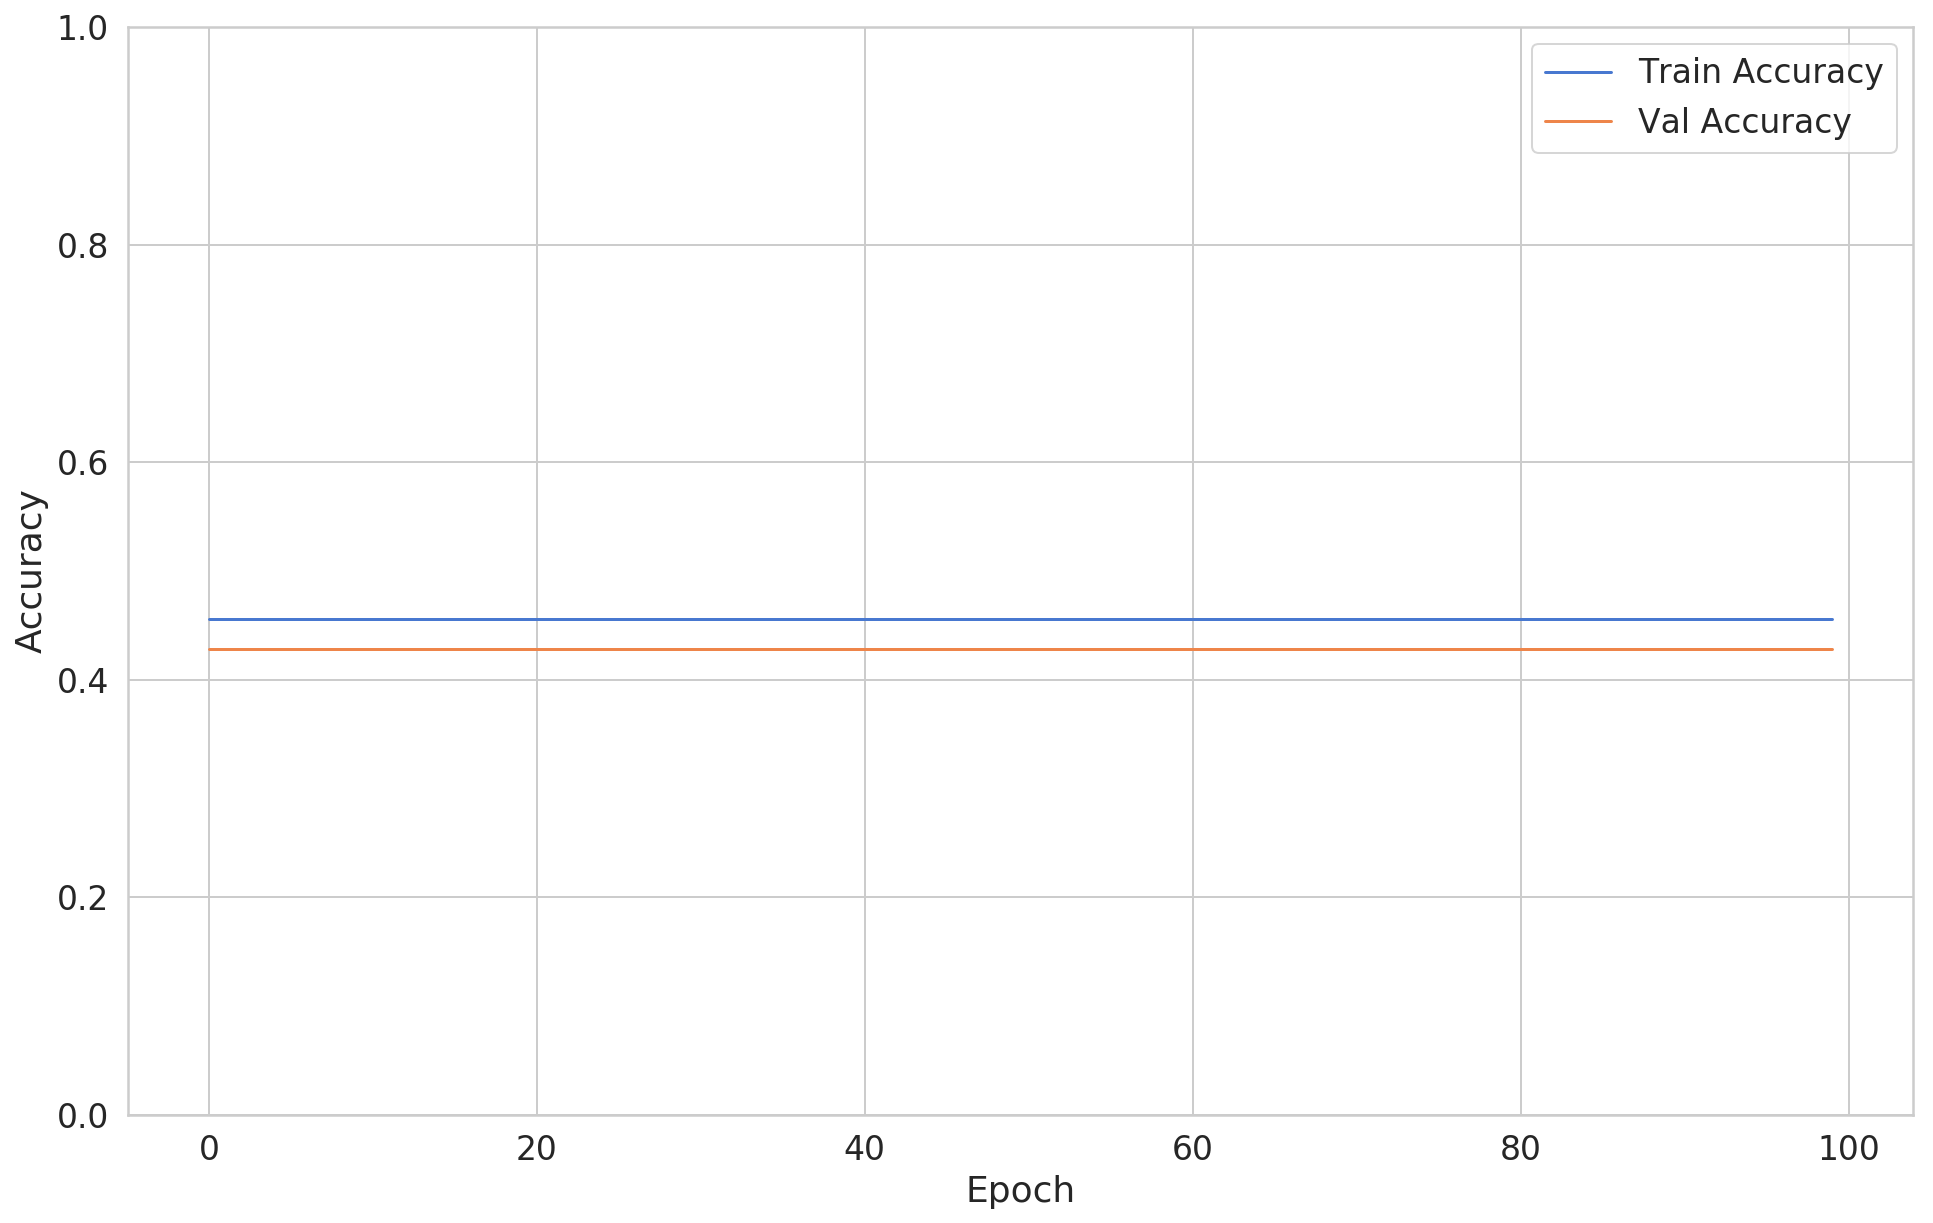

In [0]:
plot_accuracy(clf_history)

### Fix with informative features

In [0]:
X = pd.get_dummies(df[['oldpeak', 'cp']], columns=["cp"])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
clf = build_classifier(X_train)

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

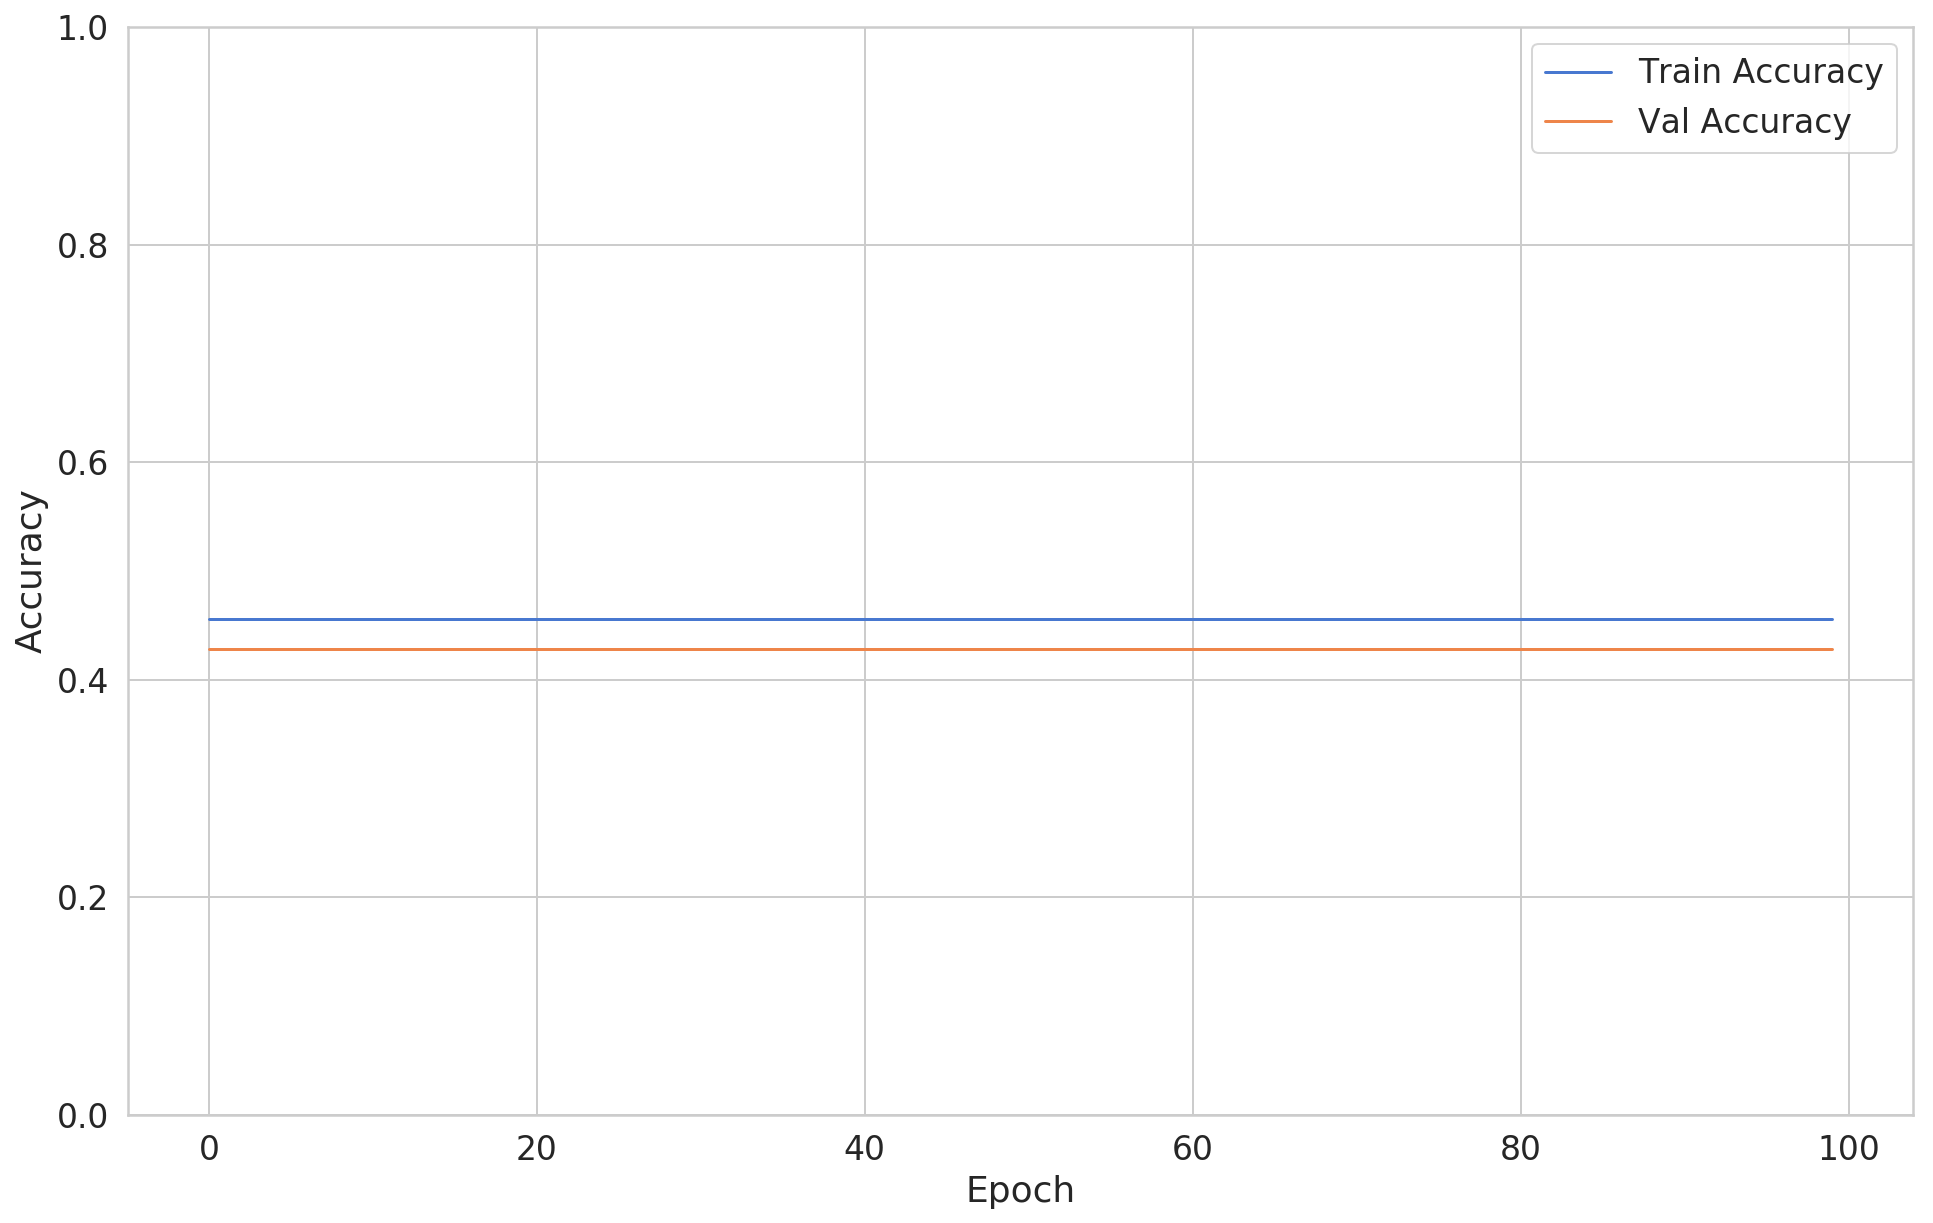

In [0]:
plot_accuracy(clf_history)

## Underpowered model

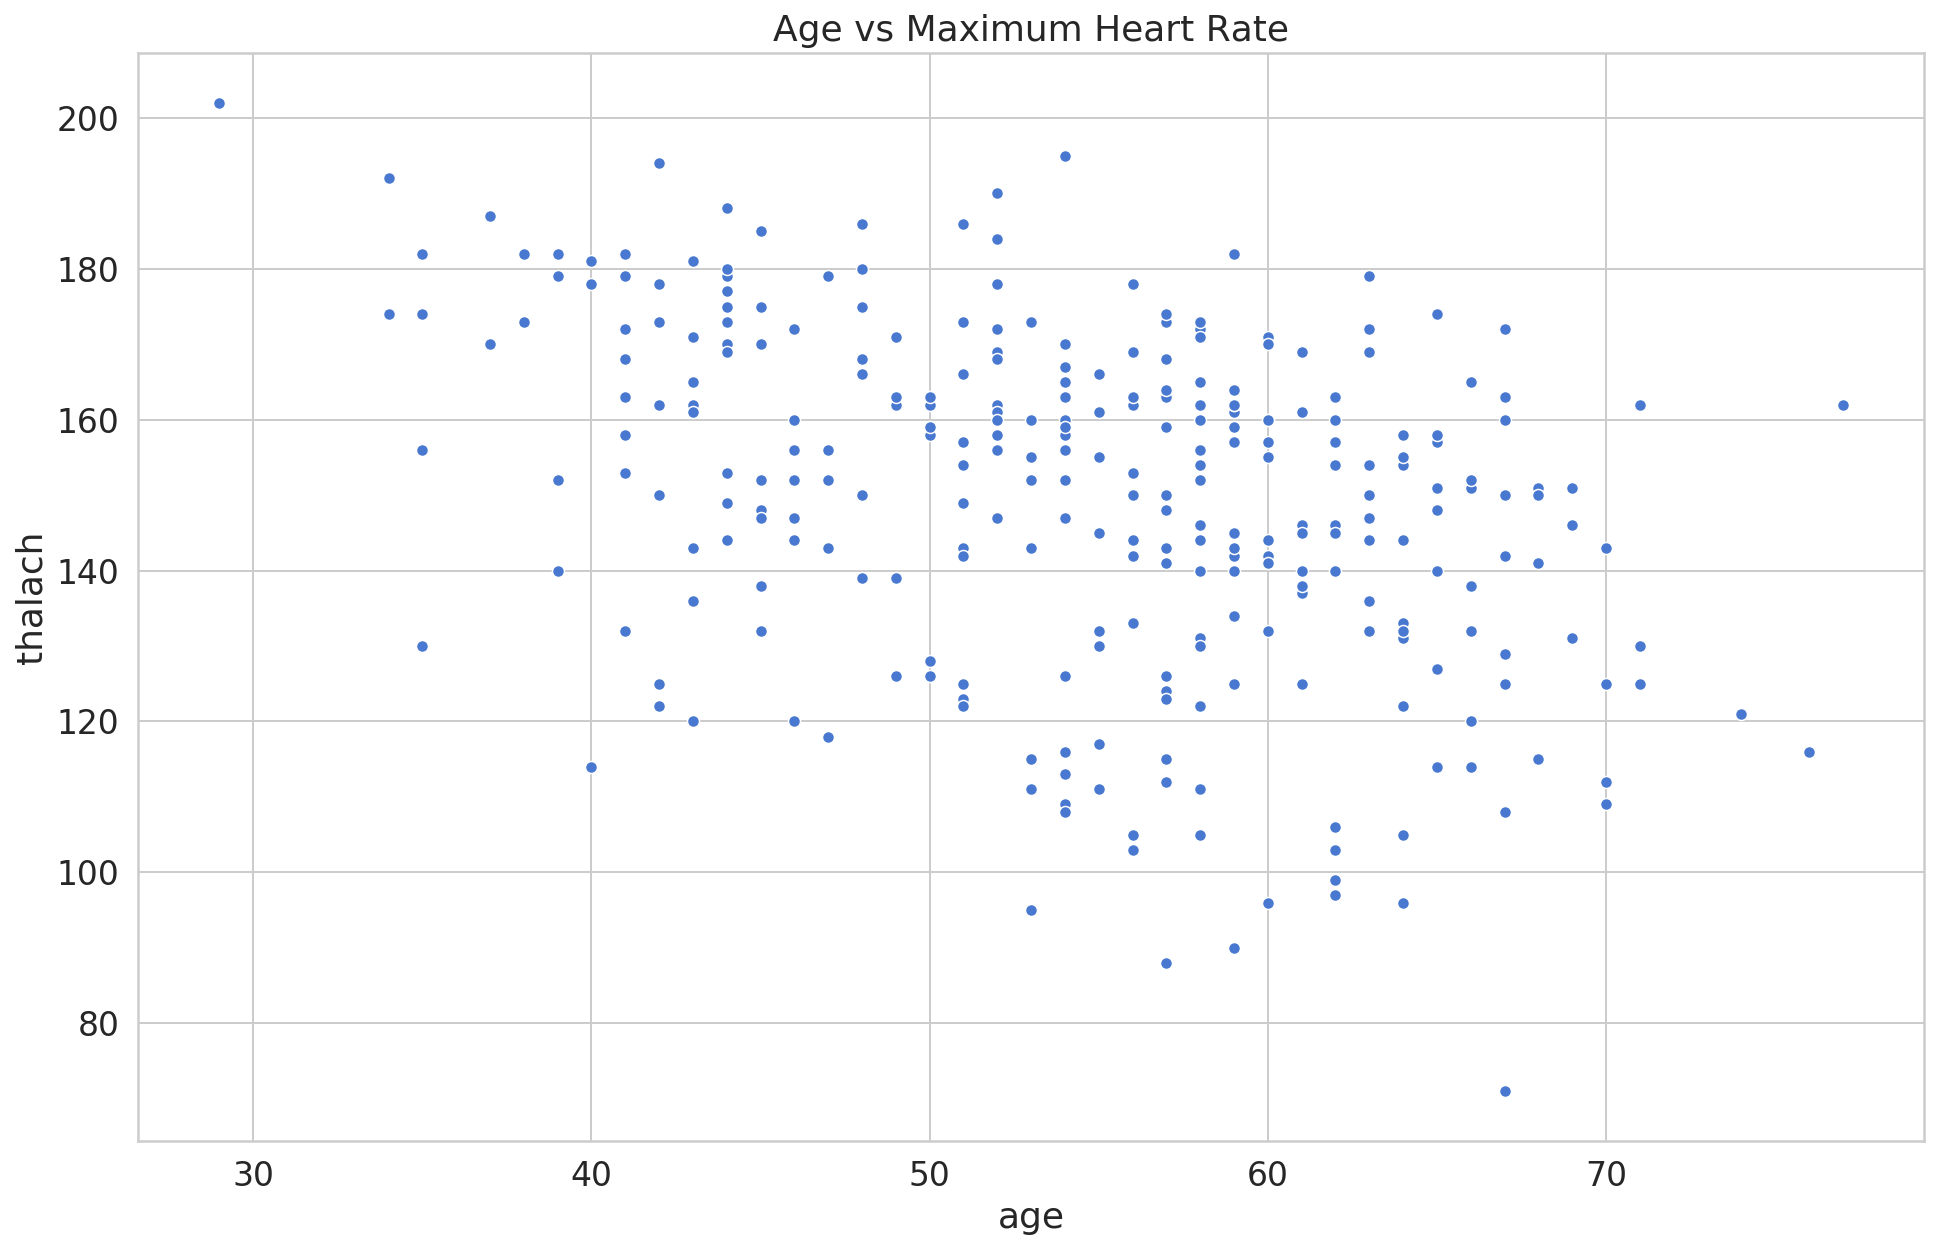

In [0]:
sns.scatterplot(df.age, df.thalach);
plt.title("Age vs Maximum Heart Rate");

In [0]:
from sklearn.preprocessing import MinMaxScaler

s = MinMaxScaler()

X = s.fit_transform(df[['age']])
y = s.fit_transform(df[['thalach']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
X_train.shape

(242, 1)

In [0]:
lin_reg = keras.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[X_train.shape[1]]),
])

lin_reg.compile(
  loss="mse",
  optimizer="adam",
  metrics=['mse']
)

In [0]:
reg_history = lin_reg.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=500,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

In [0]:
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
            label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
            label = 'Val Loss')
  plt.legend()
  plt.show()

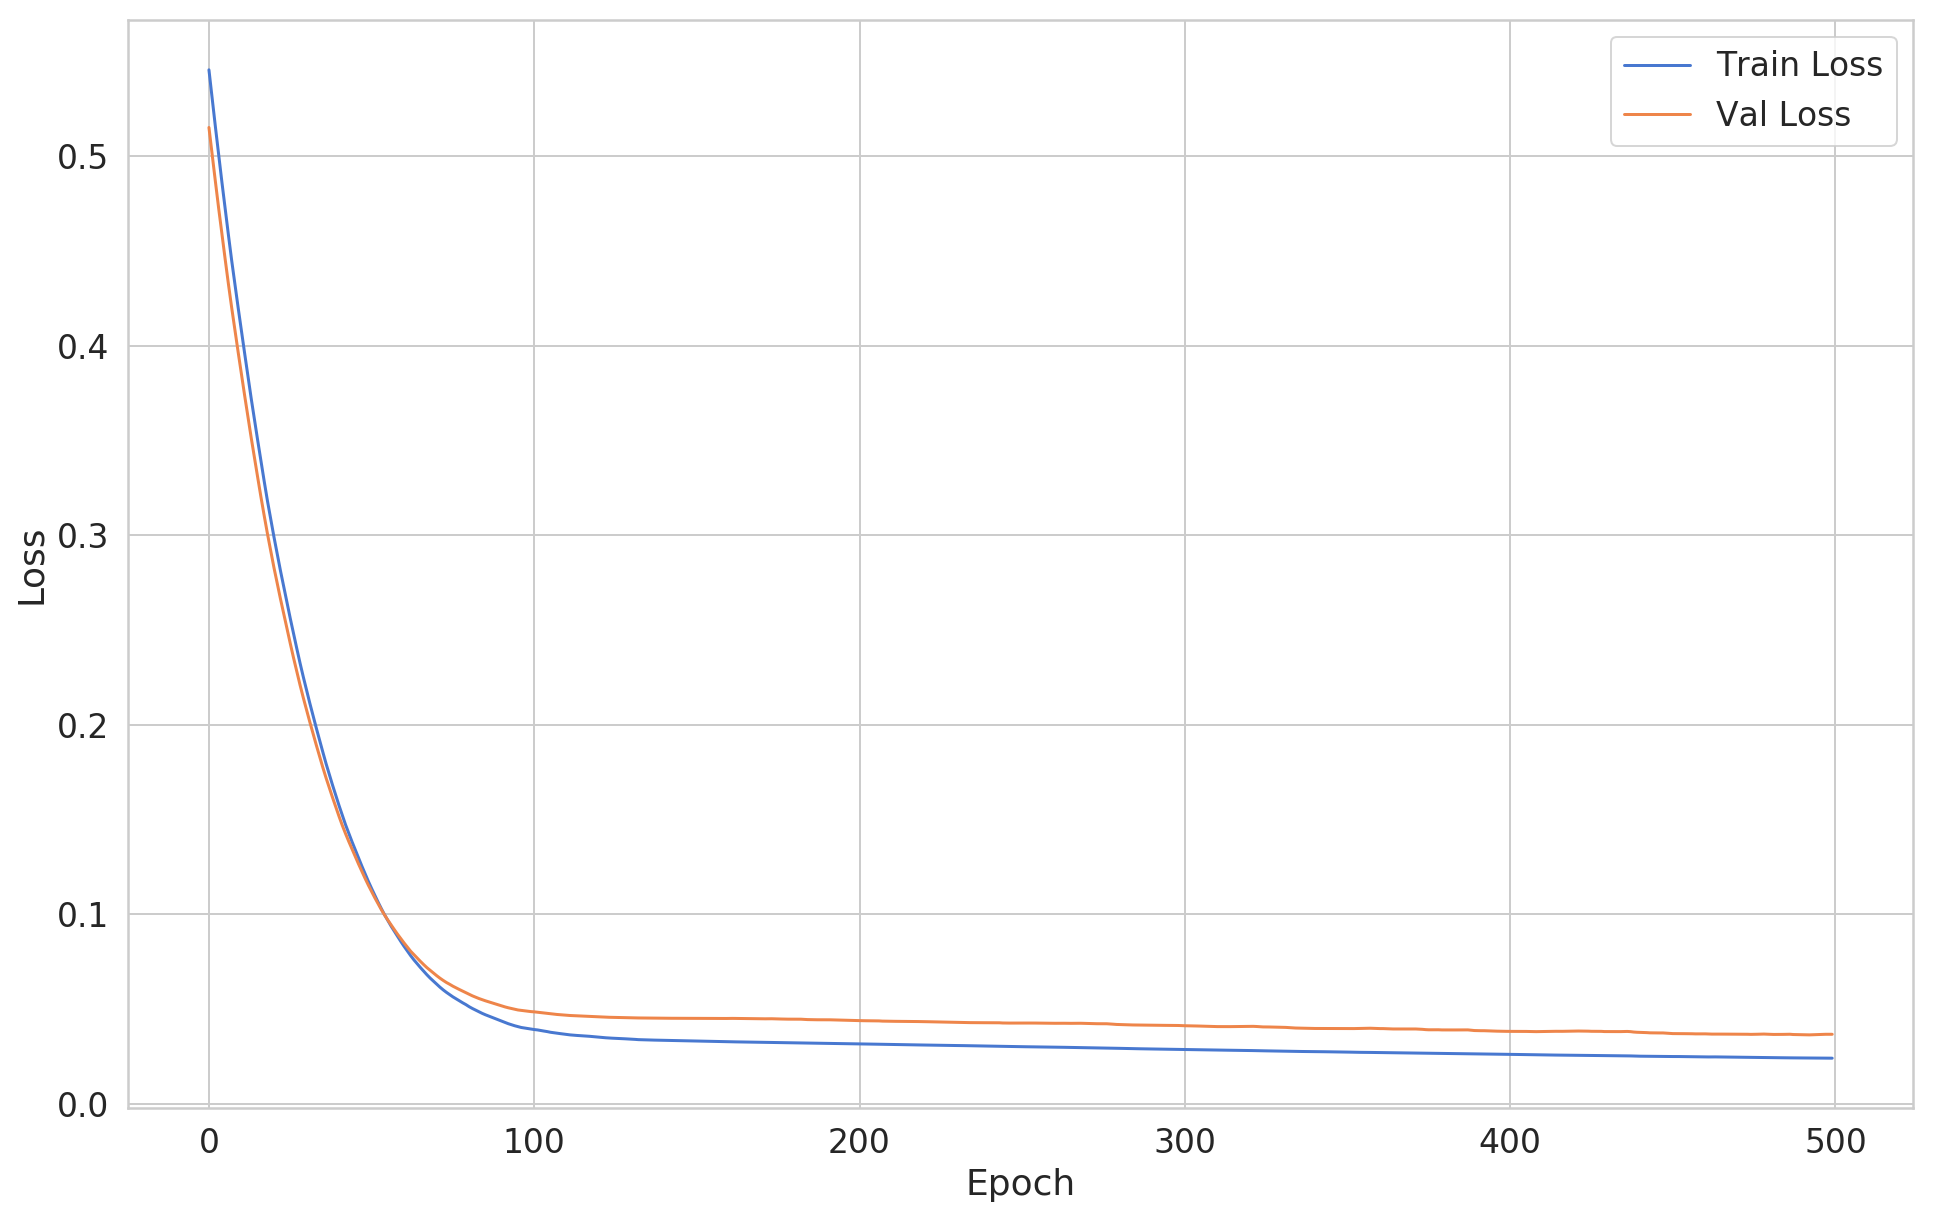

In [0]:
plot_loss(reg_history);

In [0]:
reg_history.history['val_mse'][-1]

0.03675039

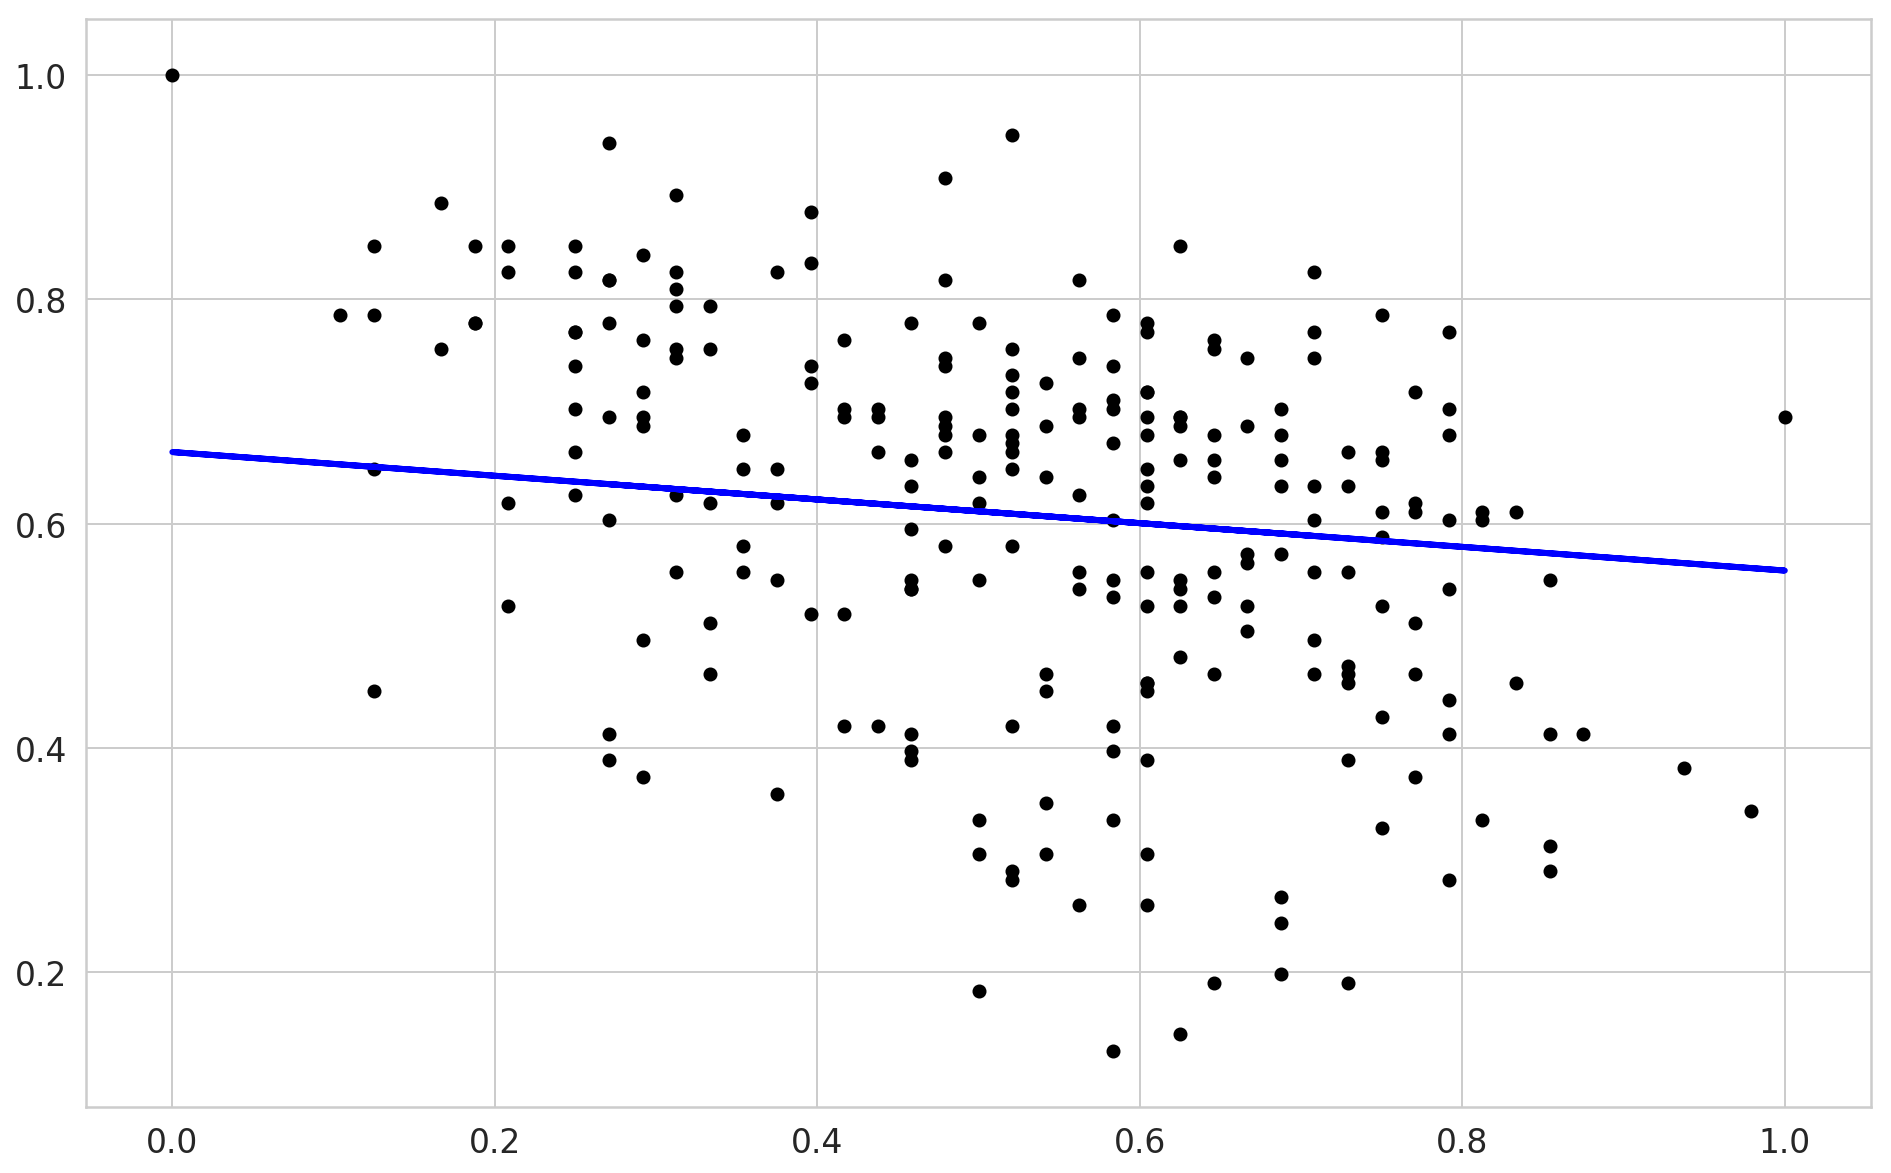

In [0]:
plt.scatter(X_train, y_train, color='black')
plt.plot(X_train, lin_reg.predict(X_train), color='blue', linewidth=3);

### Fix

Use more powerful model:

In [0]:
lin_reg = keras.Sequential([
  keras.layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(rate=0.2),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='linear'),
])

lin_reg.compile(
  loss="mse",
  optimizer="adam",
  metrics=['mse']
)

In [0]:
reg_history = lin_reg.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=200,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

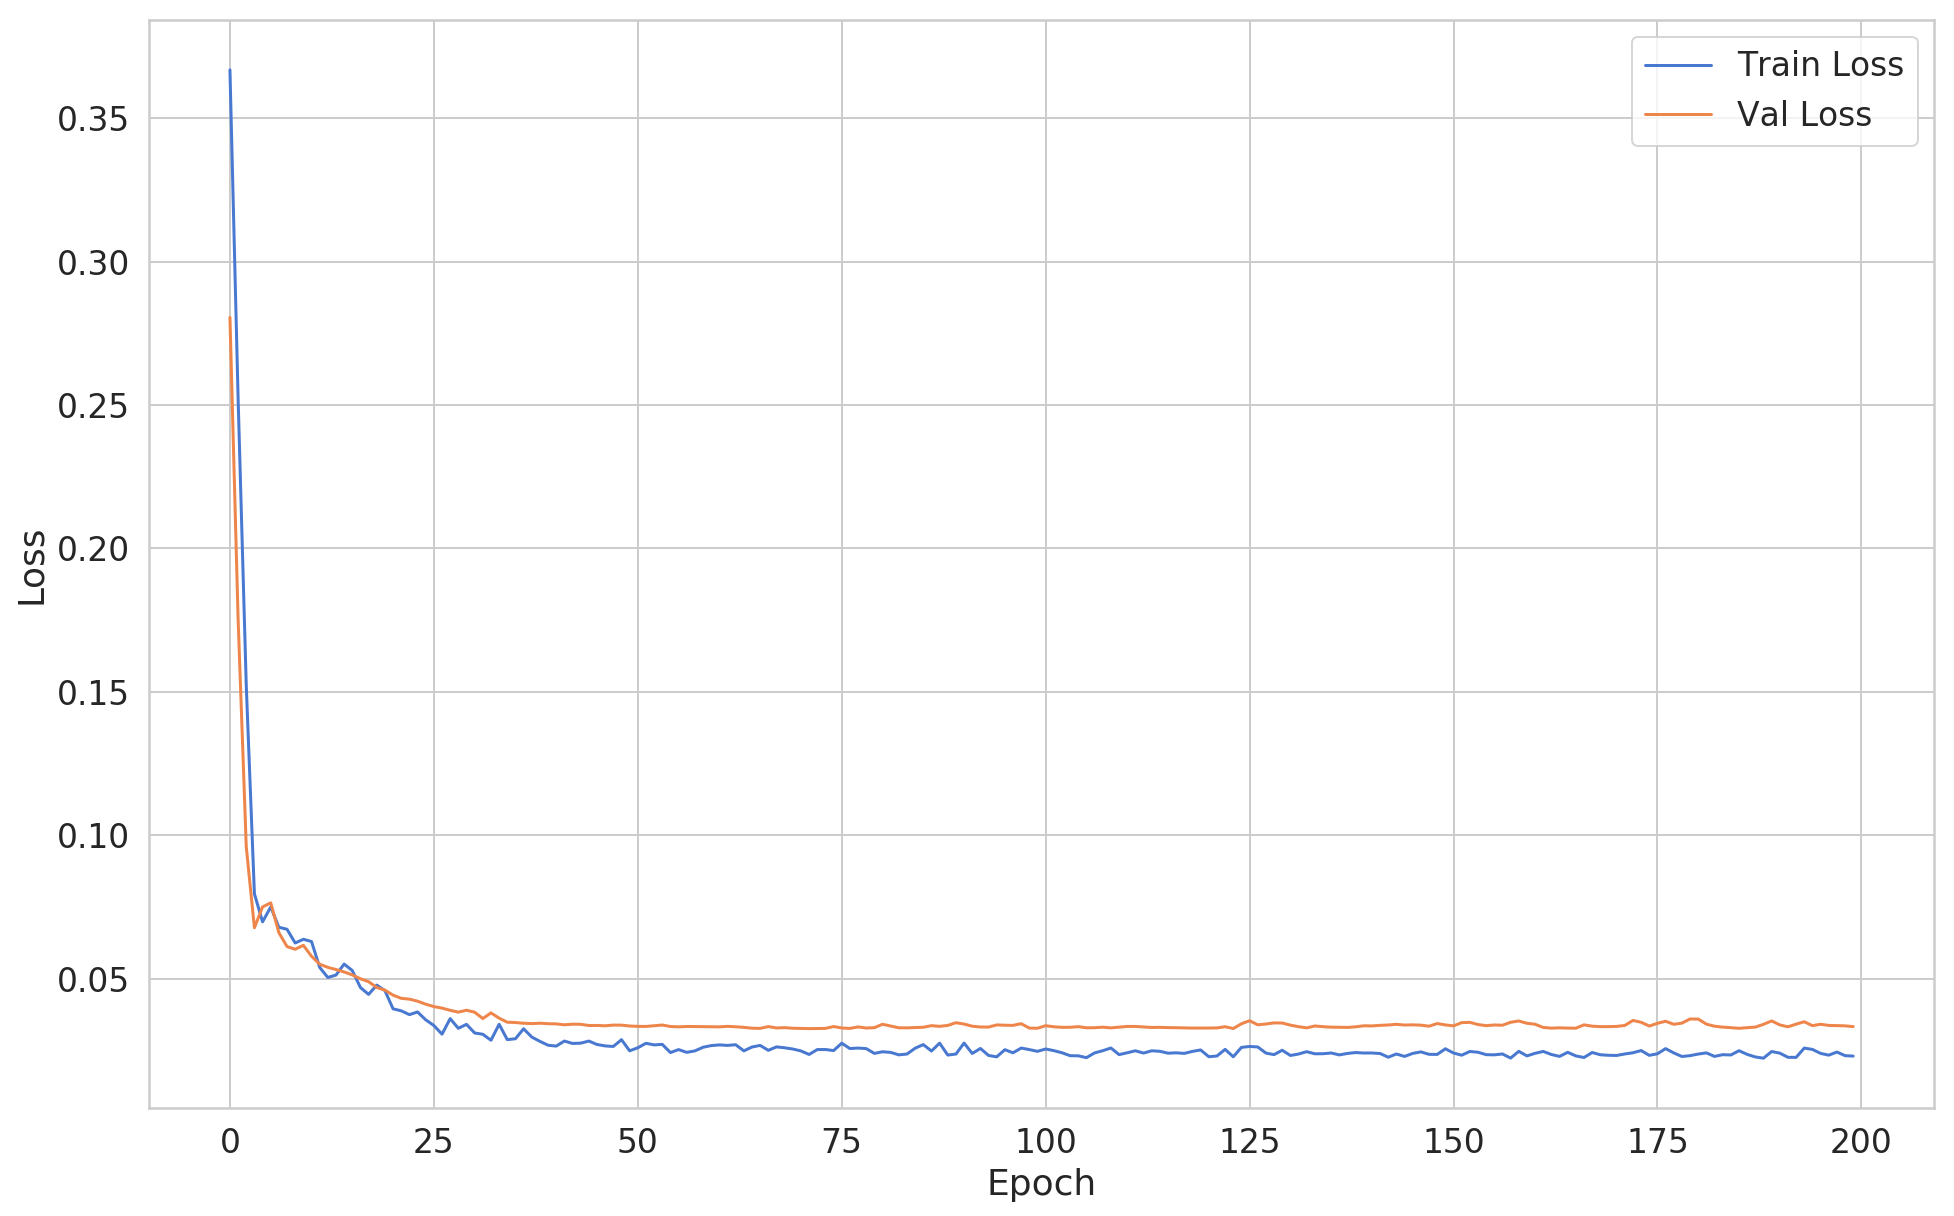

In [0]:
plot_loss(reg_history);

In [0]:
reg_history.history['val_mse'][-1]

0.03325244

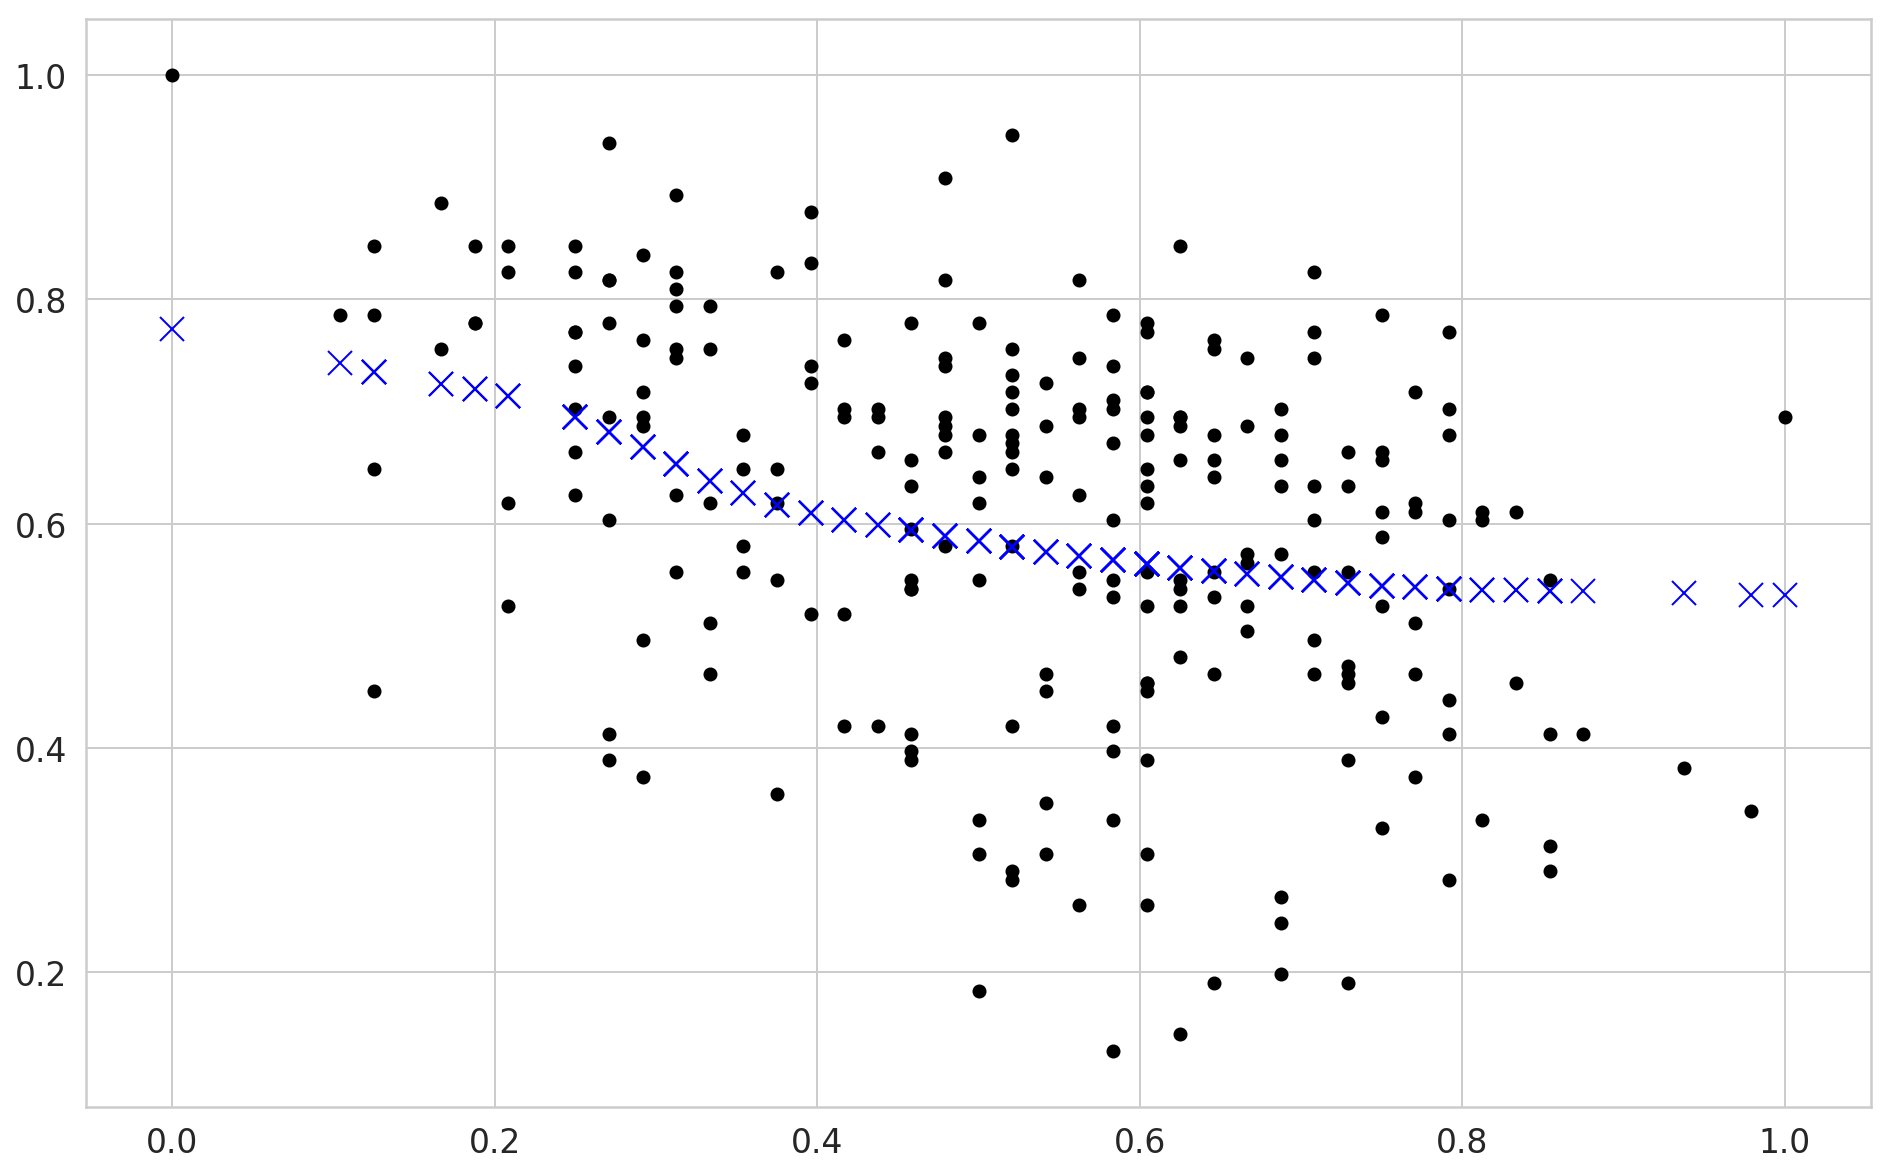

In [0]:
plt.scatter(X_train, y_train, color='black')
plt.plot(X_train, lin_reg.predict(X_train), color='blue', linestyle='None', marker='x', markersize=12);

# Overfitting

## Many features with little training examples

In [0]:
X = df[['oldpeak', 'age', 'exang', 'ca', 'thalach']]
X = pd.get_dummies(X, columns=['exang', 'ca', 'thalach'])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
def build_classifier():

  model = keras.Sequential([
    keras.layers.Dense(units=16, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

  model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
  )

  return model

In [0]:
clf = build_classifier()

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=500,
  validation_split=0.95,
  batch_size=BATCH_SIZE,
  verbose=0
)

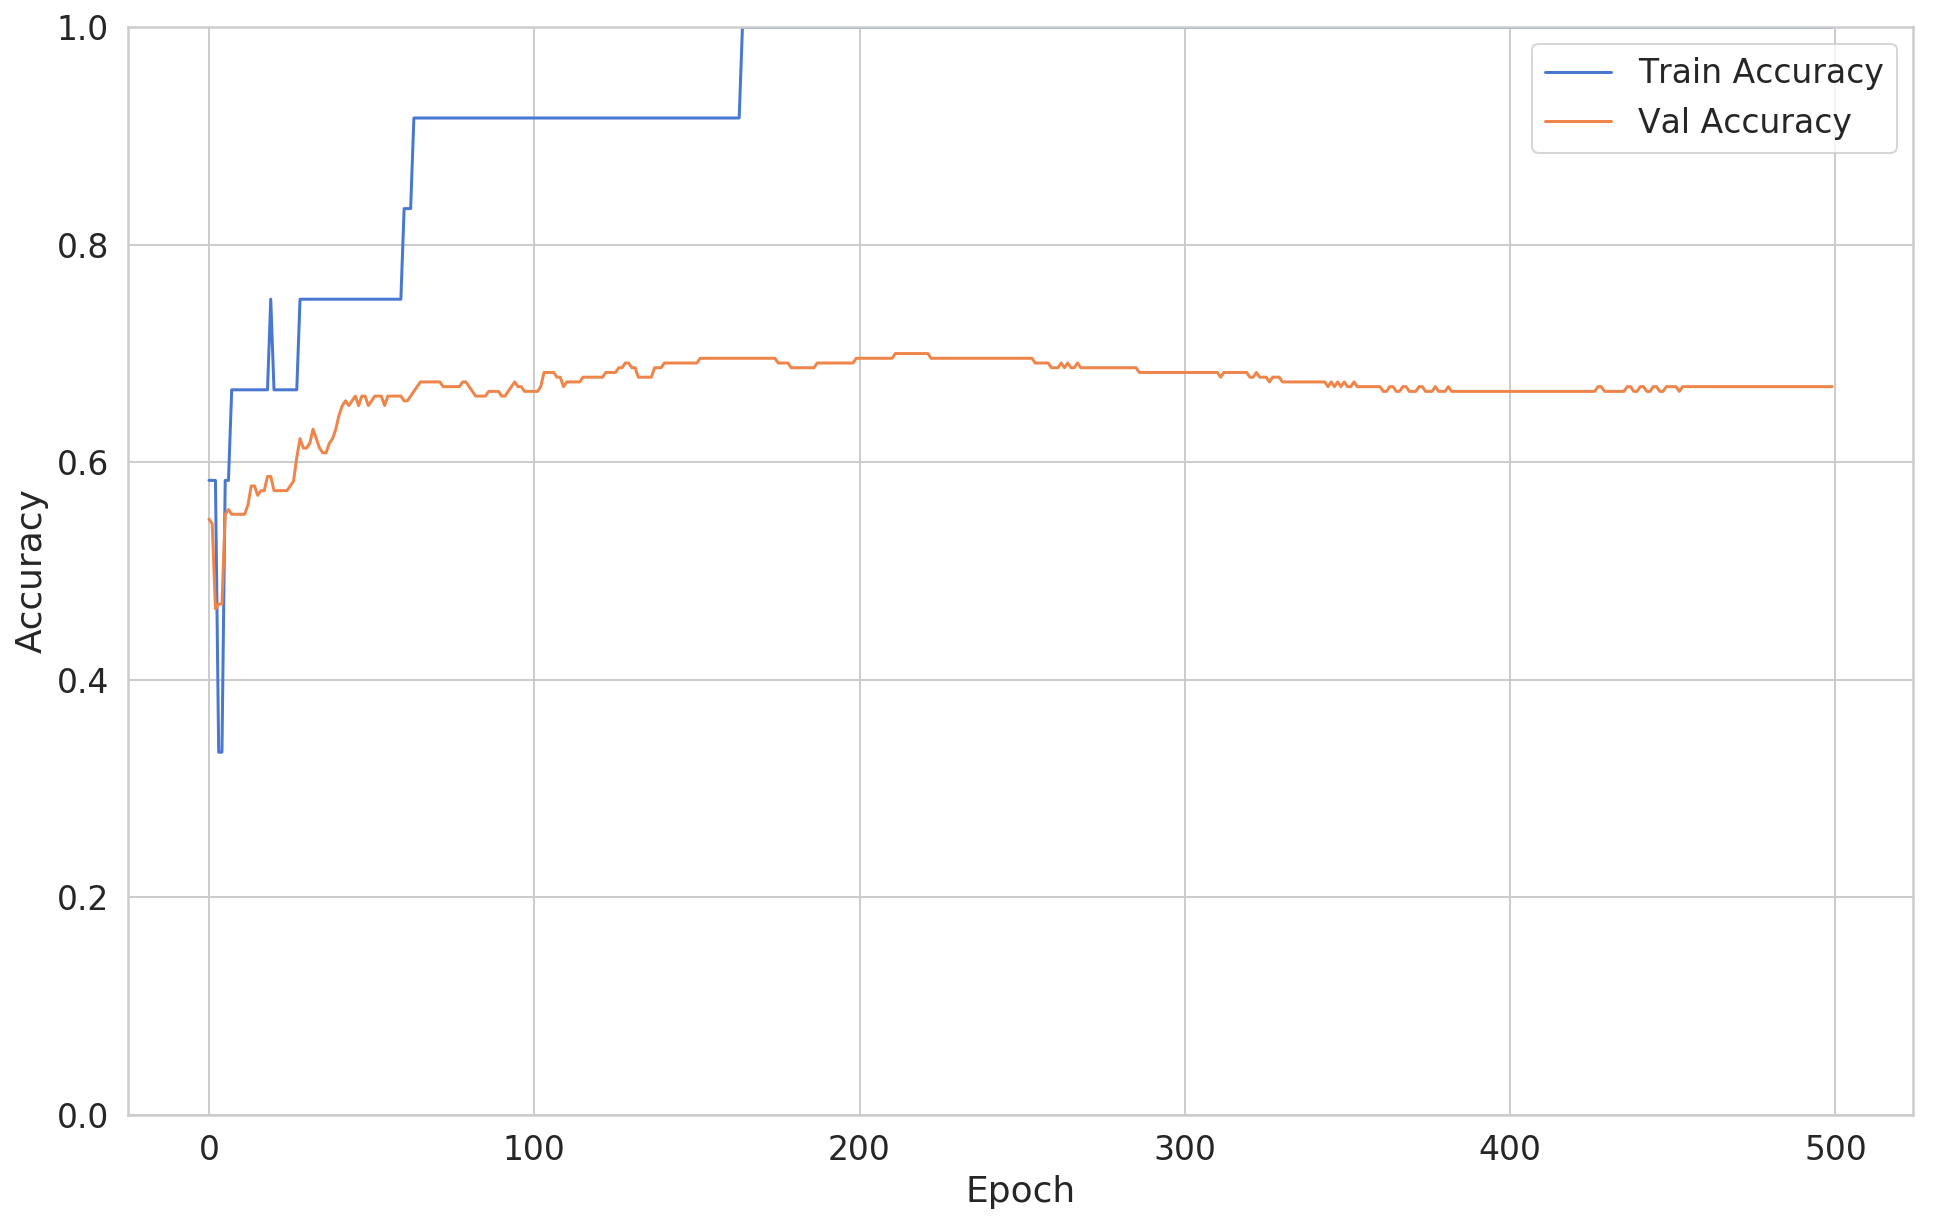

In [0]:
plot_accuracy(clf_history)

### The fix

Add more data

In [0]:
clf = build_classifier()

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=500,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

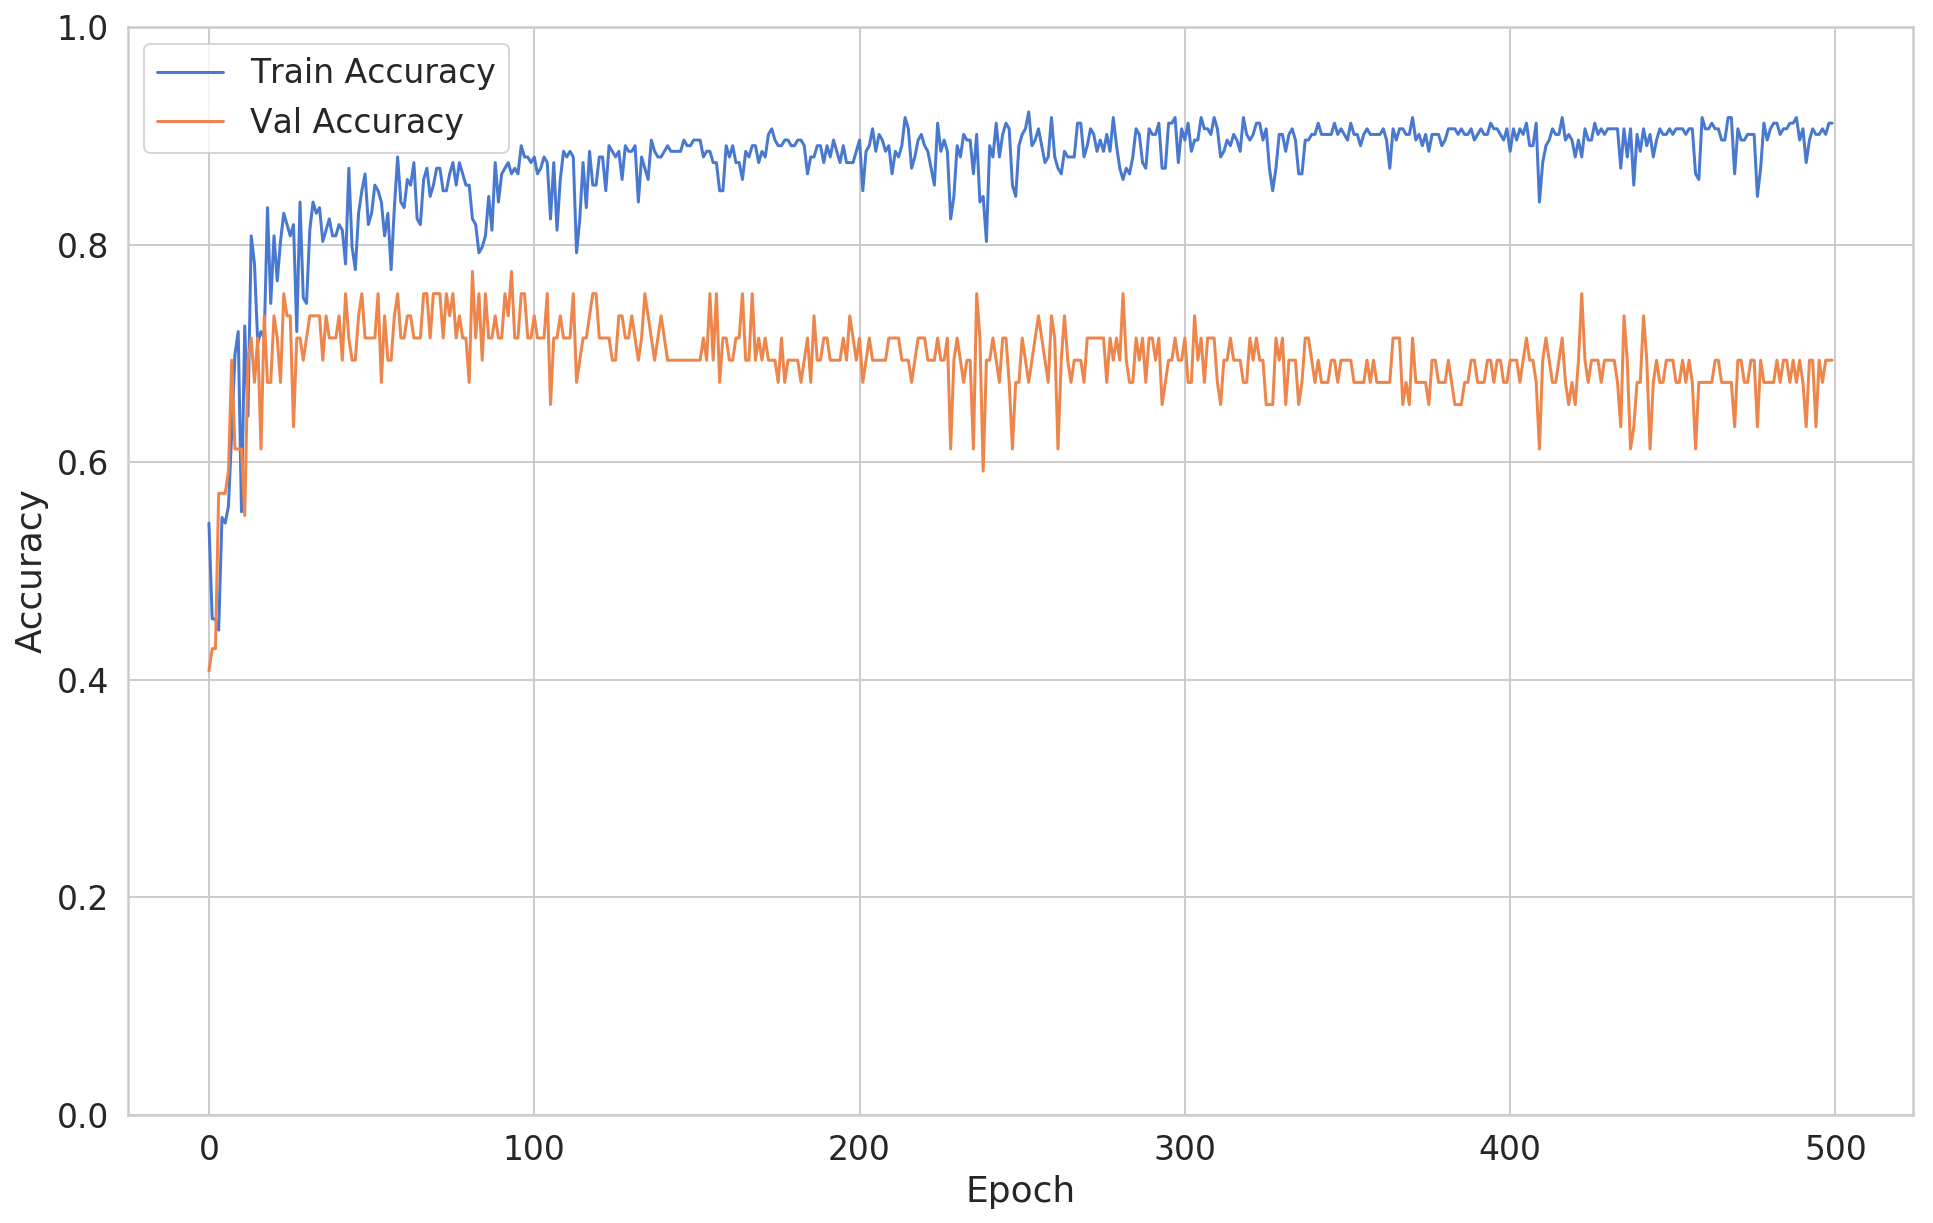

In [0]:
plot_accuracy(clf_history)

## Too complex model

In [0]:
def build_classifier():
  model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=8, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

  model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
  )

  return model

In [0]:
clf = build_classifier()

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=200,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

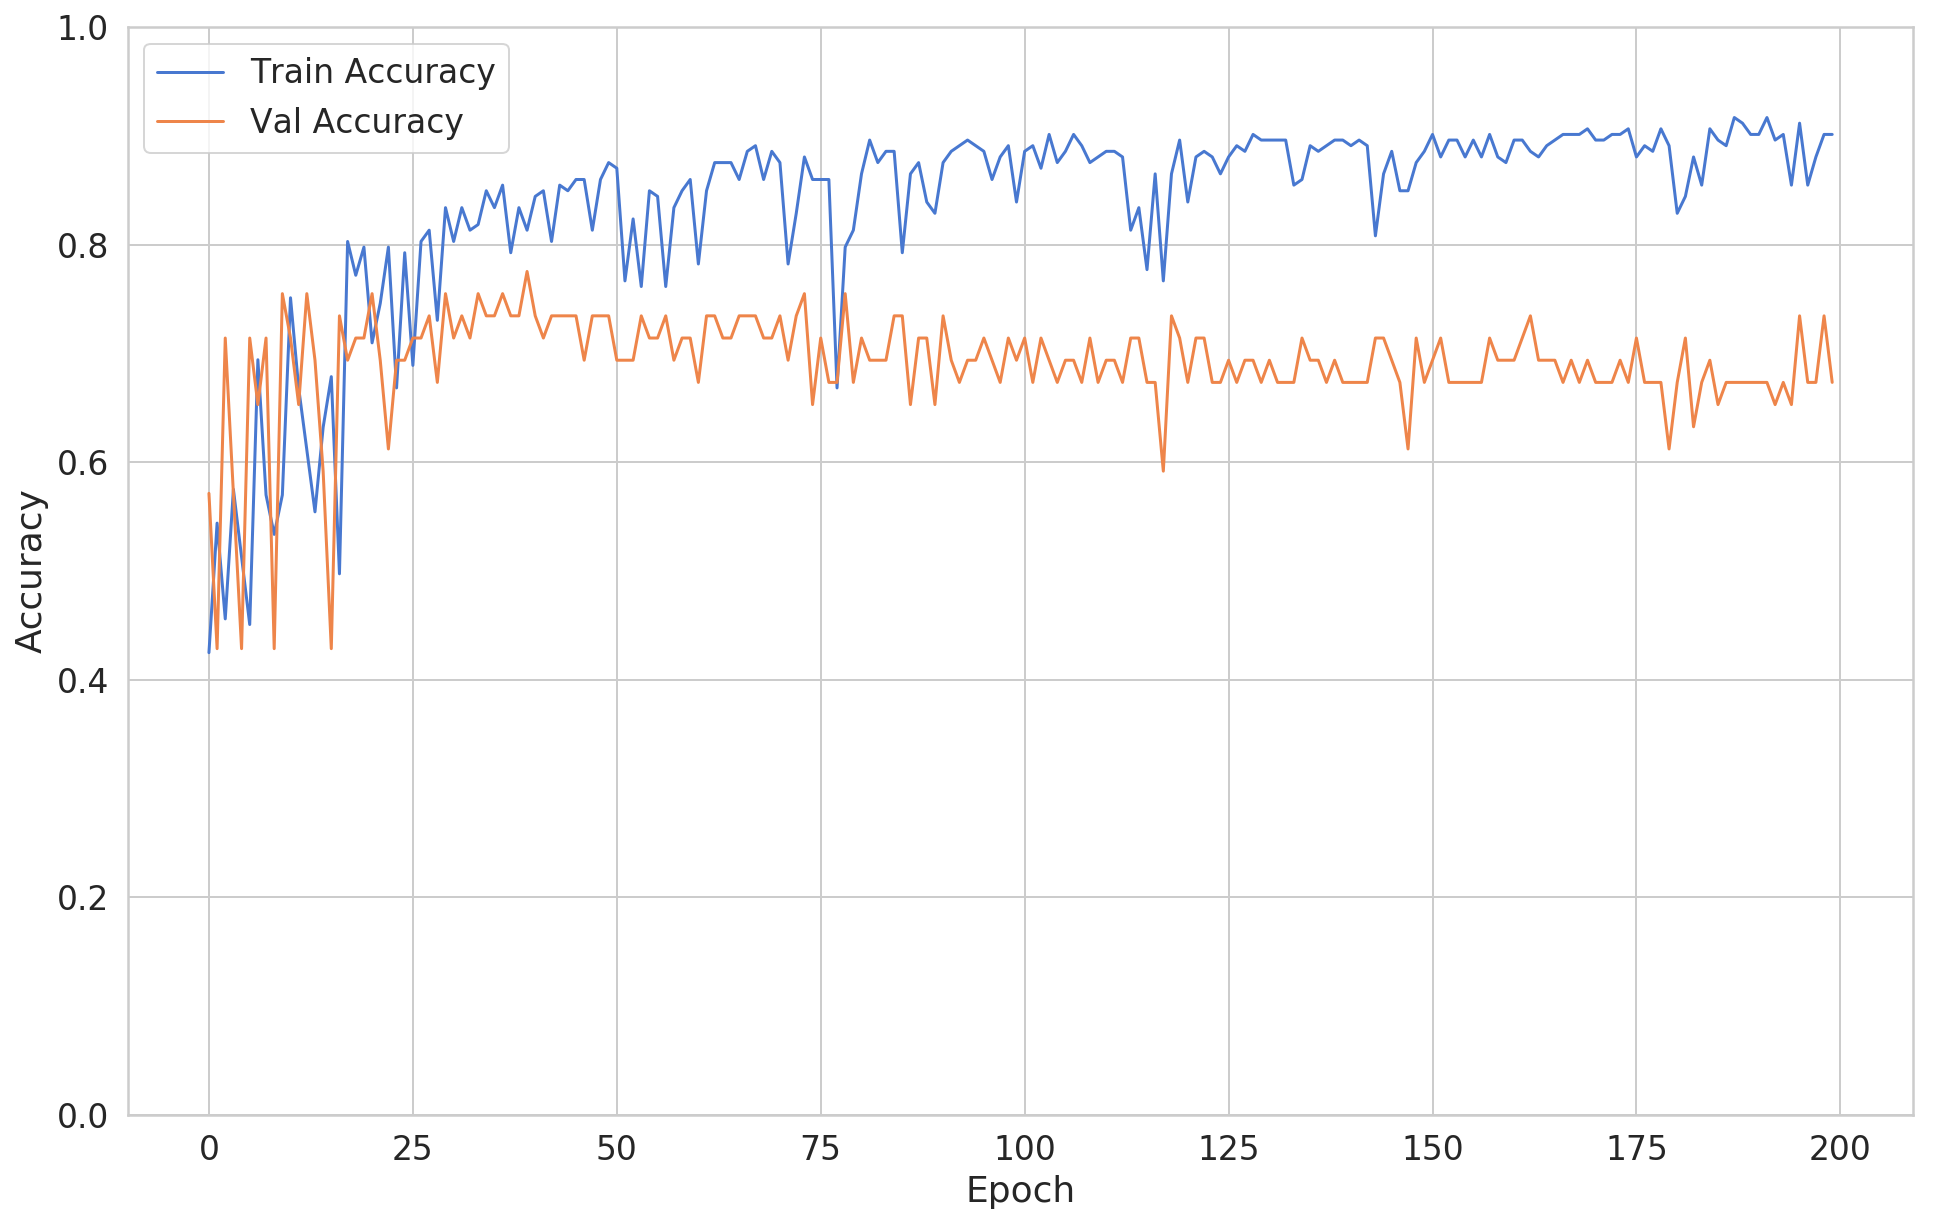

In [0]:
plot_accuracy(clf_history)

### The fix #1

Early Stopping

In [0]:
clf = build_classifier()

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

clf_history = clf.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=200,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0,
  callbacks=[early_stop]
)

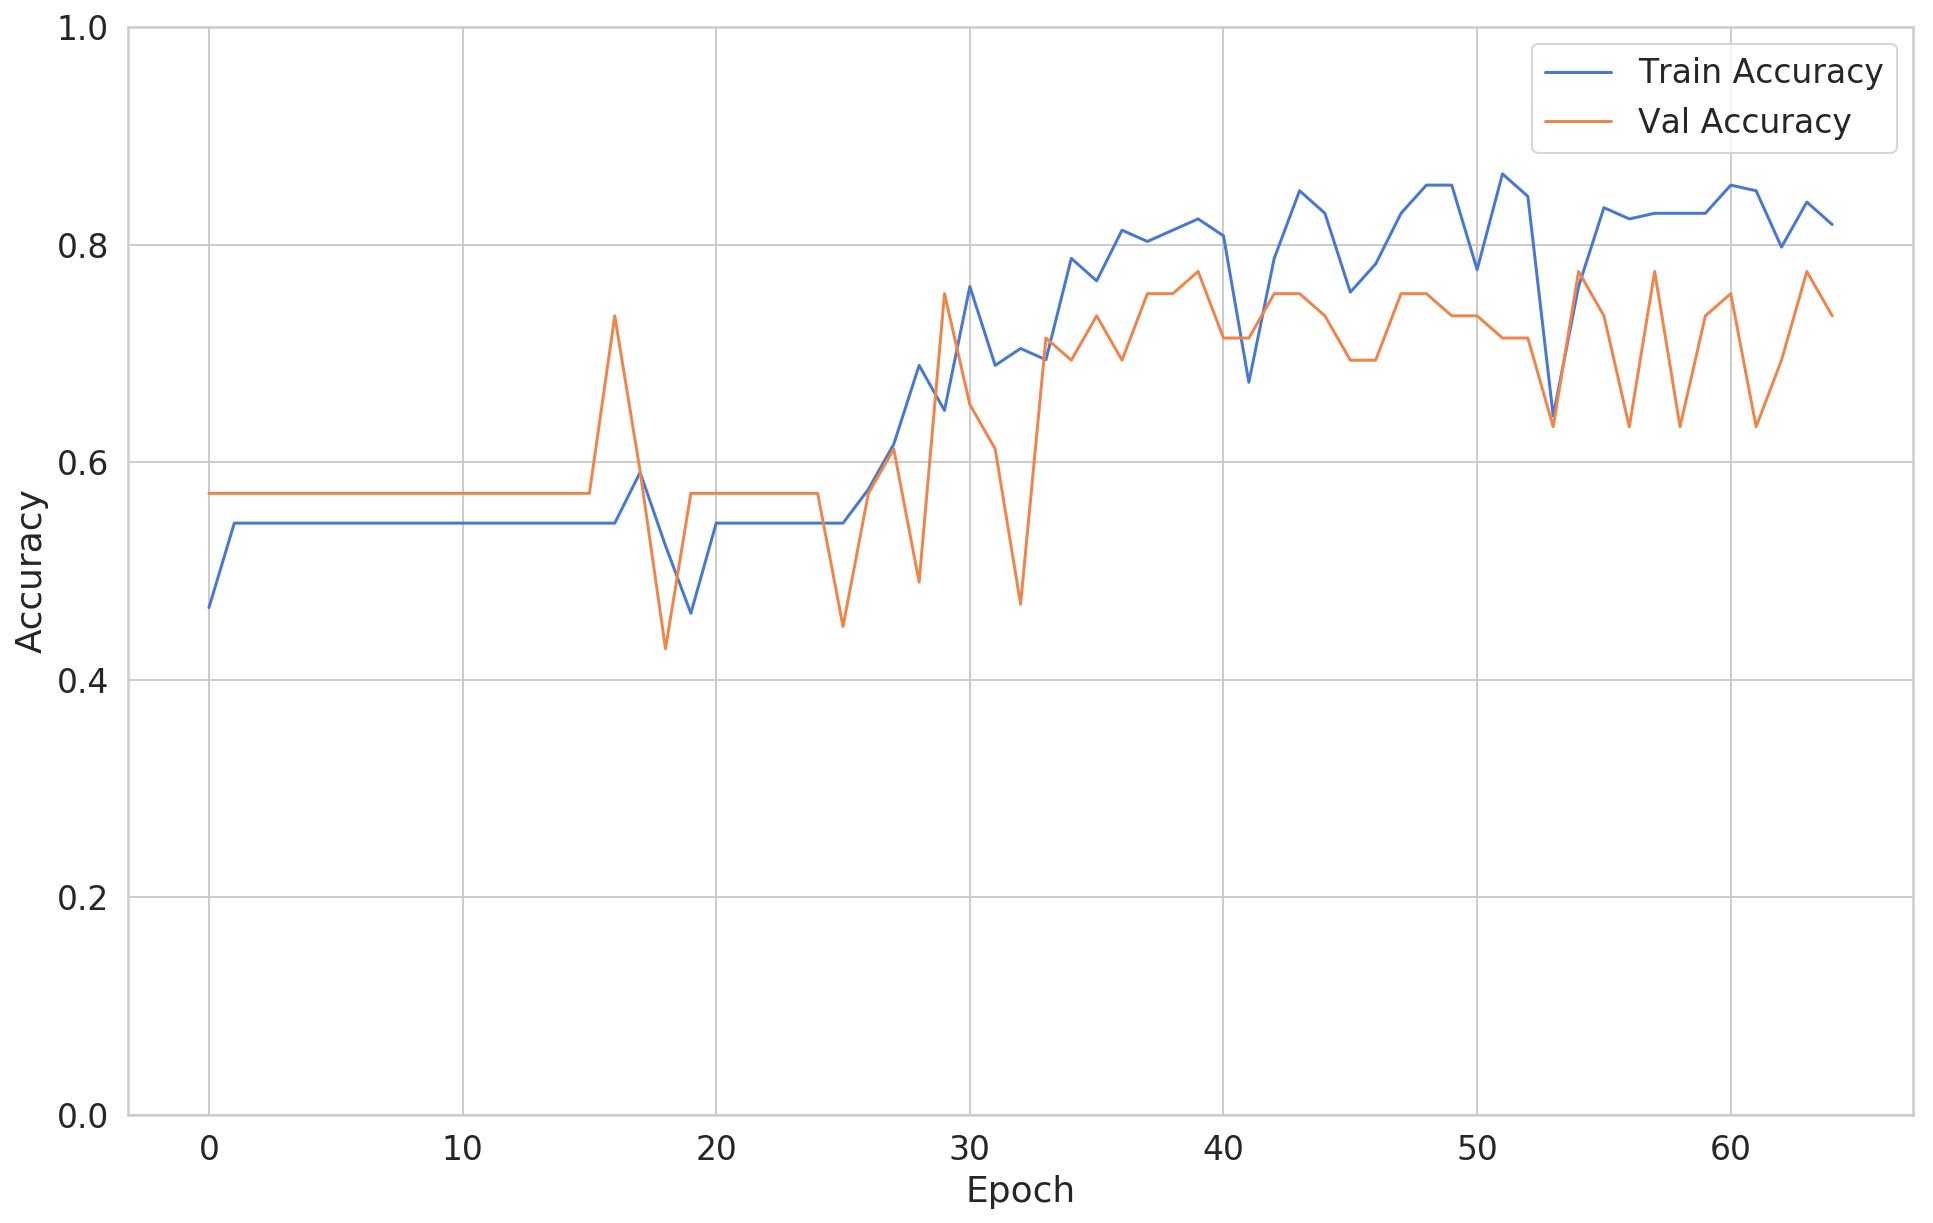

In [0]:
plot_accuracy(clf_history)

### The Fix #2

Use regularization

In [0]:
model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=8, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

model.compile(
  loss="binary_crossentropy",
  optimizer="adam",
  metrics=['accuracy']
)

In [0]:
clf_history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=200,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  verbose=0
)

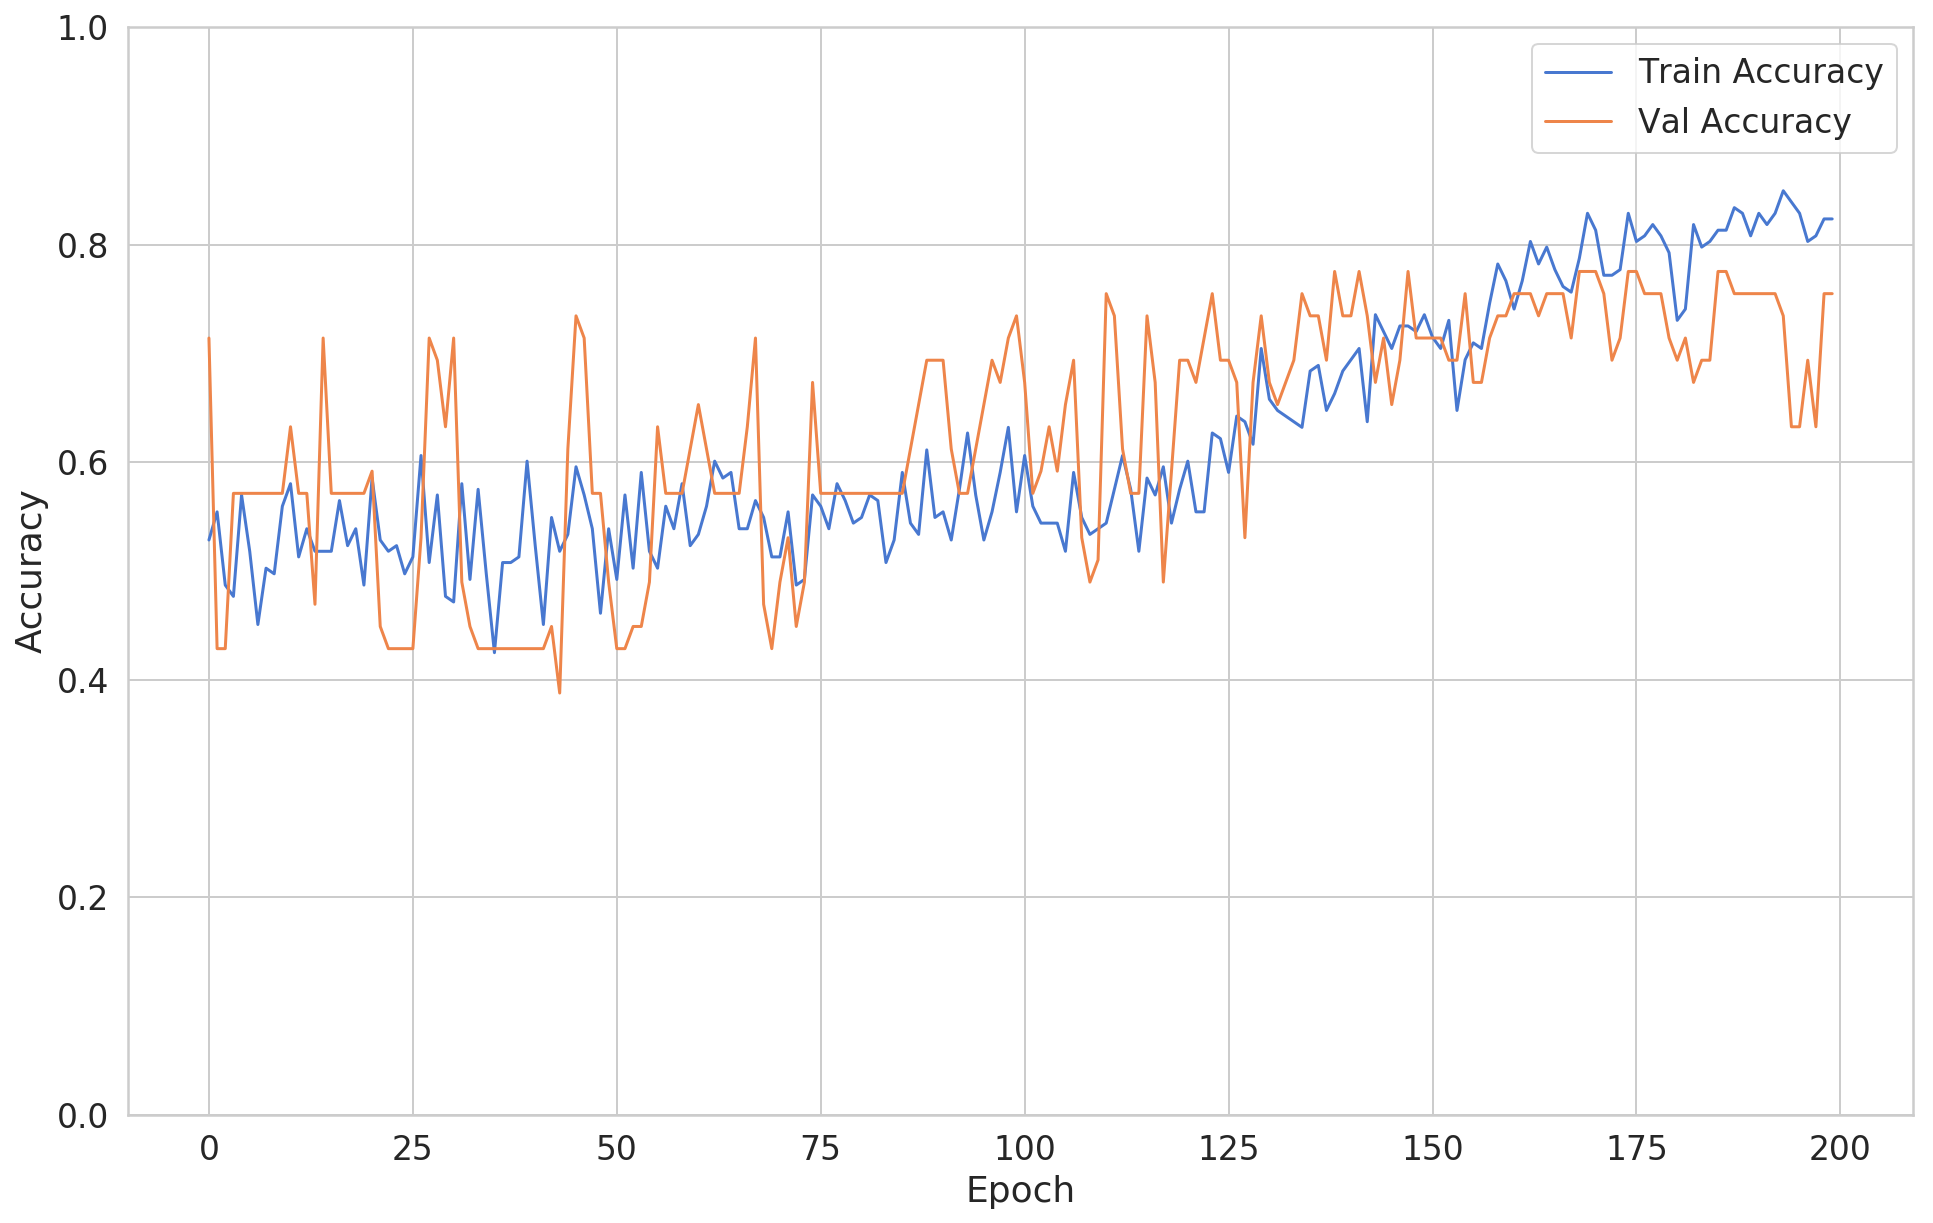

In [0]:
plot_accuracy(clf_history)